## Notes before running the code:



*   Make sure to uploade the files in the folder named "Uploads"
*   Make sure to add a chatGPT API and a Webscraping API before running
*   Most of the API codes and prompts were commented, they would take a long time to run

##Installing and importing required libararies

In [ ]:
!pip install PyPDF2

In [ ]:
!pip install openai

In [ ]:
!pip install pycryptodome

In [ ]:
!pip install requests

In [ ]:
!pip install nltk

In [ ]:
!pip install mord

In [ ]:
!pip install -U scikit-learn

In [ ]:
try:
    import PyMuPDF
except:
    !pip install PyMuPDF

In [ ]:
try:
    import fitz
except:
    !pip install fitz

In [ ]:
import PyPDF2
import openai
import os
from openai import OpenAI
import re
from Crypto.Cipher import AES
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
import numpy as np
import requests
import base64
import json
import time
import nltk
import xgboost as xgb
import mord as m
import geopandas as gpd
import statsmodels.api as sm
from textblob import TextBlob
from datetime import datetime
from PIL import Image
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.util import ngrams
from copy import deepcopy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

In [ ]:
#get the current working directory
cwd = os.getcwd()

#create the 'static/' directory if it doesn't exist
static_dir = os.path.join(cwd, 'static')
if not os.path.exists(static_dir):
    os.makedirs(static_dir)

In [ ]:
import fitz

In [ ]:
#set your OpenAI API key
API_KEY = 'Insert your API key here'
Newscrape_API = 'Insert your API key here'

os.environ['OPENAI_API_KEY'] = API_KEY
openai.api_key = os.getenv("OPENAI_API_KEY")

# OpenAI API parameters
#model = "gpt-3.5-turbo-0125"
model = "gpt-4"

#Extracting Data for Innovation Indicators

In [ ]:
#Function to extract text from document using fitz
def extract_text_from_page(pdf_path, page_number):
    # Open the PDF file
    document = fitz.open(pdf_path)
    page = document.load_page(page_number)

    # Extract text from the page
    text = page.get_text()

    return text

In [ ]:
#Function to remove special characters
def remove_special_characters_and_empty_lines(text):
    # Define a regular expression pattern to match special characters
    special_char_pattern = r'[⏲◇◆●○]'

    # Remove lines containing special characters
    lines = text.split('\n')
    filtered_lines = [line for line in lines if not re.search(special_char_pattern, line)]

    # Remove empty lines
    filtered_lines = [line for line in filtered_lines if line.strip()]

    # Join the filtered lines back into a single string
    filtered_text = '\n'.join(filtered_lines)

    return filtered_text

In [ ]:
#Function to split individual lines of PDF text which need to be separated for data extraction
def create_dataframe_from_text1(text):
    lines = text.split('\n')
    data = {}
    column_name = None

    for line in lines:
        # Check if the line matches the pattern "number.number.number"
        match = re.match(r'^(\d+\.\d+(\.\d+)+) (.*)$', line)
        if match:
            # Extract column name from the matched line
            column_name = match.group(3).strip()
        elif column_name is not None:
            # If column_name is set, use it as a column name
            column_data = line.strip()
            # Add the information to the data dictionary with the column name
            data[column_name] = column_data
            # Reset column_name for the next iteration
            column_name = None

    # Create a DataFrame from the data dictionary
    df = pd.DataFrame(data, index=[0])

    return df

In [ ]:
def create_dataframe_from_text2(text):
    lines = text.split('\n')
    data = {}

    for i in range(len(lines)):
        line = lines[i]

        # Check if the line matches the pattern "number.number.number"
        match = re.match(r'^(\d+\.\d+(\.\d+)+)$', line)
        if match:
            # Extract column name from the next line
            column_name = lines[i + 1].strip()
            # Extract information from the line after that
            information = lines[i + 2].strip()
            # Add the information to the data dictionary with the column name
            data[column_name] = information

    # Create a DataFrame from the data dictionary
    df = pd.DataFrame(data, index=[0])

    return df

In [ ]:
path = "wipo-pub-2000-2023-en-main-report-global-innovation-index-2023-16th-edition.pdf"

In [ ]:
# Define a function to extract data from a single page
def extract_data_from_page(page_number):

    # Extract text from page and clean it
    pdf_path = path
    text = extract_text_from_page(pdf_path, page_number)
    if page_number % 2 != 0:
      lines = text.split('\n')
      lines[3] += lines.pop(4)
      text = '\n'.join(lines)
    cleaned_text = remove_special_characters_and_empty_lines(text)

    # Initialize country info
    info_dict_country = {
    8: 19,
    20: 21
}

    # Extract country information
    info_data = {}
    for key, value in info_dict_country.items():
        info_data[cleaned_text.split('\n')[key - 1]] = cleaned_text.split('\n')[value - 1]

    df_country = pd.DataFrame(info_data, index=[0])


    # Extract half of the information
    df_scores1 = create_dataframe_from_text1(cleaned_text)

    # Extract other half of the information
    df_scores2 = create_dataframe_from_text2(cleaned_text)

    # Combine dataframes
    df_merged = pd.concat([df_country, df_scores1, df_scores2], axis=1)

    return df_merged

In [ ]:
# Initialize an empty list to store DataFrames for each page
df_combined = []

# Loop through pages 77 to 208 and extract data from each page
for page_number in range(76, 208):
    df_page = extract_data_from_page(page_number)
    df_combined.append(df_page)

df_all_pages = pd.concat(df_combined, ignore_index=True)

In [ ]:
innovation_scores = df_all_pages.copy()

In [ ]:
#fixing the negative values from ‒number to -number > reading error
innovation_scores.replace(to_replace='‒(\d+)', value='-\g<1>', regex=True, inplace=True)
innovation_scores.replace("n/a", pd.NA, inplace=True)

In [ ]:
#adding a continent column to be sorted according to it
new_column_Continent = pd.Series(['Europe','Africa','Africa','South America','Asia','Oceania','Europe','Asia','Asia','Asia','Europe','Europe','Africa','South America','Europe','Africa','South America','Africa','Europe','Africa','Africa','Africa',
                          'Asia','Asia','North America','South America','Asia','South America','North America','Africa','Europe','Europe','Europe','Europe','North America','South America','Africa','North America','Europe','Africa','Europe','Europe','Europe',
                          'Europe','Africa','Europe','North America','Africa','North America','Asia','Europe','Europe','Asia','Asia','Asia','Europe','Asia','Europe','North America','Asia','Asia','Asia','Africa','Asia','Asia','Asia','Europe','Asia','Europe',
                          'Europe','Africa','Asia','Asia','Europe','Africa','Africa','North America','Asia','Europe','Africa','Africa','Africa','Asia','Europe','Oceania','North America','Africa','Africa','Europe','Europe','Asia','Asia','North America','South America',
                          'South America','Asia','Europe','Europe','Asia','Asia','Europe','Europe','Asia','Africa','Asia','Africa','Europe','Asia','Europe','Europe','Africa','Europe','Asia','Europe','Europe','Asia','Asia','Oceania','North America','Asia',
                          'Asia','Africa','Europe','Asia','Europe','Africa','North America','South America','Asia','Asia','Africa','Africa'])

#adding an OECD column
new_column_OECD = pd.Series([None,None,None,None,None,'Yes','Yes',None,None,None,None,'Yes',None,None,None,None,None,None,None,None,None,None,None,None,'Yes','Yes',None,'Yes','Yes',None,None,None,'Yes','Yes',None,None,None,None,'Yes',None,'Yes',None,None,
                             'Yes',None,'Yes',None,None,None,None,'Yes','Yes',None,None,None,'Yes','Yes','Yes',None,'Yes',None,None,None,None,None,None,'Yes',None,'Yes','Yes',None,None,None,None,None,None,'Yes',None,None,None,None,None,None,'Yes','Yes',None,
                             None,None,None,'Yes',None,None,None,None,None,None,'Yes','Yes',None,None,None,None,None,None,None,None,None,None,'Yes','Yes',None,'Yes',None,'Yes','Yes',None,None,None,None,None,'Yes',None,None,None,'Yes',None,'Yes',None,None,None,None,None])

innovation_scores.insert(1, 'Continent', new_column_Continent)
innovation_scores.insert(1, 'OECD', new_column_OECD)
innovation_scores = innovation_scores.rename(columns={'Region': 'Country'})
innovation_scores.replace('Hong Kong, China', 'Hong Kong China', regex=True, inplace=True)
#making sure not numbers are stored as strings
convert_to_numeric = lambda x: pd.to_numeric(x, errors='ignore') if isinstance(x, str) else x
innovation_scores = innovation_scores.applymap(convert_to_numeric)


In [ ]:
innovation_scores

Country  OECD      Continent  GII 2023 rank  \
0       Albania  None         Europe             83   
1       Algeria  None         Africa            119   
2        Angola  None         Africa            132   
3     Argentina  None  South America             73   
4       Armenia  None           Asia             72   
..          ...   ...            ...            ...   
127     Uruguay  None  South America             63   
128  Uzbekistan  None           Asia             82   
129    Viet Nam  None           Asia             46   
130      Zambia  None         Africa            118   
131    Zimbabwe  None         Africa            117   

    University–industry R&D collaboration† State of cluster development†  \
0                                     61.8                          34.0   
1                                     28.9                          41.5   
2                                      0.0                           1.6   
3                                     33.5                          26.8   
4                                     28.6                          21.2   
..                                     ...                           ...   
127                                   43.5                          37.8   
128                                   62.4                          66.1   
129                                   65.3                          68.8   
130                                   38.6                          38.8   
131                                   14.5                           5.8   

    GERD financed by abroad, % GDP  \
0                             <NA>   
1                              0.0   
2                             <NA>   
3                              0.1   
4                              0.0   
..                             ...   
127                            0.0   
128                            0.0   
129                            0.0   
130                           <NA>   
131                           <NA>   

    Joint venture/strategic alliance deals/bn PPP$ GDP  \
0                                                  0.0   
1                                                  0.0   
2                                                  0.0   
3                                                  0.0   
4                                                  NaN   
..                                                 ...   
127                                                0.0   
128                                                0.0   
129                                                0.0   
130                                                0.0   
131                                                0.0   

    Patent families/bn PPP$ GDP Intellectual property payments, % total trade  \
0                           0.0                                           0.7   
1                           0.0                                           0.3   
2                           0.0                                           0.5   
3                           0.1                                           2.1   
4                           0.1                                           0.0   
..                          ...                                           ...   
127                         0.1                                           0.9   
128                         0.0                                           0.5   
129                         0.0                                           0.3   
130                         0.0                                           0.3   
131                         0.0                                           0.1   

     ...  School life expectancy, years  \
0    ...                           14.3   
1    ...                           <NA>   
2    ...                           <NA>   
3    ...                           18.1   
4    ...                           13.5   
..   ...                            ...   
127  .

# Main Model

In [ ]:
innovation_scores[innovation_scores['Country'] == 'Canada']

Country OECD      Continent  GII 2023 rank  \
24  Canada  Yes  North America             15   

    University–industry R&D collaboration†  State of cluster development†  \
24                                    85.8                           77.5   

    GERD financed by abroad, % GDP  \
24                             0.2   

    Joint venture/strategic alliance deals/bn PPP$ GDP  \
24                                                0.3    

    Patent families/bn PPP$ GDP  \
24                          2.0   

    Intellectual property payments, % total trade  ...  \
24                                            2.6  ...   

    School life expectancy, years  PISA scales in reading, maths and science  \
24                           16.6                                      516.7   

    Pupil–teacher ratio, secondary  ICT access*  ICT use*  \
24                             9.6         79.5      83.6   

    Government’s online service*  E-participation*  \
24                          83.5              82.6   

    Finance for startups and scaleups†  \
24                                64.8   

    Domestic credit to private sector, % GDP  \
24                                       NaN   

    Loans from microfinance institutions, % GDP  
24                                          NaN  

[1 rows x 84 columns]

In [ ]:
print('Number of null value:', innovation_scores.isnull().sum().sum())

Number of null value: 1279


In [ ]:
def ImputingSingleColMissingValues(df):
    print("Percentage of null values initially: ")
    print(df.isnull().sum() * 100 / len(df))

    # Drop columns with more than 50% missing values
    columns_to_drop = df.columns[df.isnull().sum() * 100 / len(df) > 50]
    df.drop(columns_to_drop, axis=1, inplace=True)

    # Impute missing values based on continent for numeric columns
    for col in df.select_dtypes(include=['number']).columns:
        if 'Continent' in df.columns:
            df[col] = df.groupby('Continent')[col].transform(lambda x: x.fillna(x.median()))
        else:
            df[col].fillna(df[col].median(), inplace=True)

    # For categorical columns, impute missing values with mode
    for col in df.select_dtypes(include=['object', 'category']).columns:
        mode_value = df[col].mode()[0]
        df[col].fillna(mode_value, inplace=True)

    print("Percentage of null values after imputation: ")
    print(df.isnull().sum() * 100 / len(df))

    assert df.isnull().values.sum() == 0, "There are still missing values remaining!"

    #making sure not numbers are stored as strings
    for column in df.columns:
      for index, value in df[column].items():
        if isinstance(value, (str)):
          if ',' in value:
            float_value = float(value.replace(',', ''))
            df.at[index, column] = float_value

    return df

innovation_scores  = ImputingSingleColMissingValues(innovation_scores)

train_df = innovation_scores.drop('Country', axis=1)

train_df = train_df.drop('Continent', axis=1)

Percentage of null values initially: 
Country                                     0.0
Continent                                   0.0
GII 2023 rank                               0.0
University–industry R&D collaboration†      0.0
State of cluster development†               0.0
                                           ... 
ICT use*                                    0.0
Government’s online service*                0.0
E-participation*                            0.0
Finance for startups and scaleups†          0.0
Domestic credit to private sector, % GDP    0.0
Length: 81, dtype: float64
Percentage of null values after imputation: 
Country                                     0.0
Continent                                   0.0
GII 2023 rank                               0.0
University–industry R&D collaboration†      0.0
State of cluster development†               0.0
                                           ... 
ICT use*                                    0.0
Government’s online servic

In [ ]:
N = 132  # Total number of ranks
train_df['GII 2023 rank'] = N + 1 - innovation_scores['GII 2023 rank']

<ipython-input-259-4d6dc2ac70cb>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = train_df.corr()


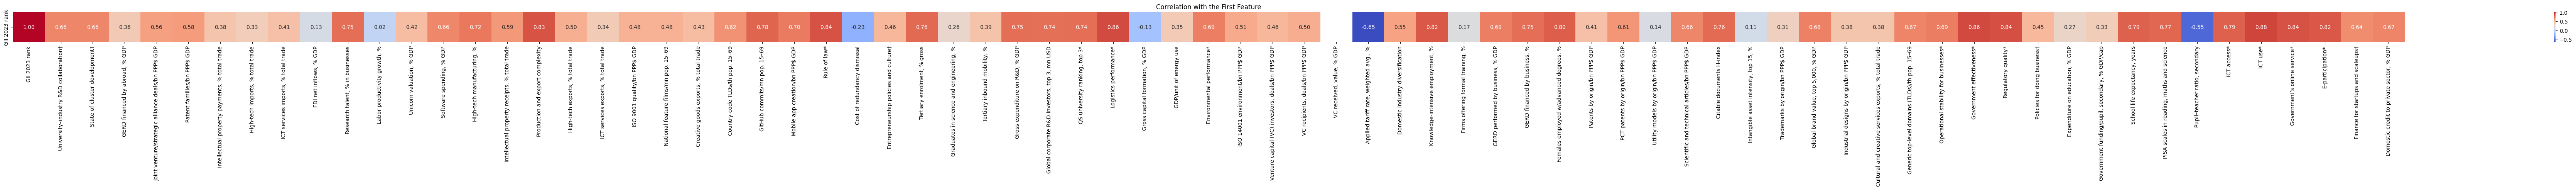

In [ ]:
plt.figure(figsize=(100, 1))
corr = train_df.corr()
sns.heatmap(corr.iloc[0:1], annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation with the First Feature')
# Save the figure
plt.savefig('plot.png', format='png', bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
X = train_df.drop(['GII 2023 rank'], axis=1)
y = train_df['GII 2023 rank']

# split training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

In [ ]:
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Feature importance
feature_importances = model.feature_importances_

# Mapping feature importance scores to feature names
features = list(X.columns)
importance_dict = dict(zip(features, feature_importances))
sorted_importance = sorted(importance_dict.items(), key=lambda item: item[1], reverse=True)

for feature, importance in sorted_importance:
    print(f"{feature}: {importance}")

Patent families/bn PPP$ GDP: 0.5157044649954167
ICT use*: 0.16128295471018583
ICT access*: 0.056355317245559436
Country-code TLDs/th pop. 15–69: 0.028802179966279807
Logistics performance*: 0.02399627850982636
Regulatory quality*: 0.02355863000307162
Government effectiveness*: 0.02315711653579632
Government’s online service*: 0.01643075480087733
PCT patents by origin/bn PPP$ GDP: 0.011484456715515361
Citable documents H-index: 0.010154699199212023
Gross expenditure on R&D, % GDP: 0.009035091160694331
High-tech manufacturing, %: 0.008988119961249312
GitHub commits/mn pop. 15–69: 0.008839195959155624
Tertiary enrolment, % gross: 0.007041985369028356
Mobile app creation/bn PPP$ GDP: 0.006895556200588566
ISO 14001 environment/bn PPP$ GDP: 0.006814045402604479
E-participation*: 0.00524735339434752
Generic top-level domains (TLDs)/th pop. 15–69: 0.004818318122936941
Production and export complexity: 0.004749146175882654
Market capitalization, % GDP: 0.004664215818267037
Industrial designs by

In [ ]:
canada_index = innovation_scores[innovation_scores['Country'] == 'Canada'].index[0]
canada_features = X_train.iloc[canada_index:canada_index+1]

# Features of interest
features_of_interest = ['Logistics performance', 'ICT use', 'ICT access', 'Regulatory quality', 'GitHub commits/mn pop. 15-69',
           'Patent families/bn PPP$ GDP', "Government's online service", 'Expenditure on education, % GDP',
           'Graduates in science and engineering, %','Policies for doing business']

increments = [0, 0.01, 0.05, 0.10, 0.2, 0.3, 0.5]

for increment in increments:
    modified_canada_features = deepcopy(canada_features)

    # Adjust all features of interest by the same increment
    for feature in features_of_interest:
        if feature in modified_canada_features.columns:
            original_value = modified_canada_features.at[canada_index, feature]
            modified_value = original_value * (1 + increment)
            modified_canada_features.at[canada_index, feature] = modified_value

    # Predict the modified rank for Canada with the collectively adjusted features
    modified_rank = model.predict(modified_canada_features)[0]
    print(f"Adjusting features by {increment*100}% results in a rank of {modified_rank}")

Adjusting features by 0% results in a rank of 115.73
Adjusting features by 1.0% results in a rank of 115.73
Adjusting features by 5.0% results in a rank of 115.73
Adjusting features by 10.0% results in a rank of 115.66
Adjusting features by 20.0% results in a rank of 115.7
Adjusting features by 30.0% results in a rank of 115.93
Adjusting features by 50.0% results in a rank of 115.88


In [ ]:
class OrdinalLogisticRegression():
    # Accept logistic regression hyperparameters as args to __init__
    def __init__(self, max_iter=100, C=1.0, solver='lbfgs', penalty='l2'):
        self.max_iter = max_iter
        self.C = C
        self.solver = solver
        self.penalty = penalty

        self.classes_ = []
        self.models_ = []

    def fit(self, X, y):
        self.classes_ = sorted(np.unique(y))
        self.models_ = []

        # Train k-1 binary logistic regression models
        for i, c in enumerate(self.classes_[:-1]): # We need only k-1 classifiers
            y_i = np.where(y <= c, 0, 1) # TODO: label is 0 if the salary bucket is 0 to c-1, otherwise label is 1
            if len(np.unique(y_i)) < 2:
              print(f"Only one class present for threshold {c}: {np.unique(y_i)}")
              print("This should not happen. Investigate the cause.")
              continue  # Skip this iteration or handle the case as appropriate
            model =  LogisticRegression(max_iter=self.max_iter, C=self.C, solver=self.solver, penalty=self.penalty) # TODO: what machine learning model should be here?
            model.fit(X, y_i)
            self.models_.append(model)

        return self

    def predict_proba(self, X):
        assert len(self.models_) > 0, "Model is not fitted yet. Run .fit() first."

        # Compute binary probabilities for each threshold
        binary_probabilities = [model.predict_proba(X)[:, 1] for model in self.models_]

        # Initial probability (probability of being in the first class or less)
        proba = [1 - binary_probabilities[0]]

        # Probabilities for intermediate classes
        for i in range(1, len(self.models_)):
            proba.append(binary_probabilities[i-1] - binary_probabilities[i])

        # Probability of being in the last class
        proba.append(binary_probabilities[-1])

        # Convert list to NumPy array for efficient operations
        proba = np.array(proba).T

        # Normalize the probabilities row-wise
        proba_norm = proba / np.sum(proba, axis=1, keepdims=True)

        # Check if probabilities sum up to 1 within a tolerance
        if not np.allclose(proba_norm.sum(axis=1), 1, atol=1e-5):
            raise AssertionError('There is a problem in the probability computation. Probabilities do not sum up to 1.')

        return proba_norm

    def predict(self, X):
        proba = self.predict_proba(X)
        return np.argmax(proba, axis = 1)

    # Add hyperparameters here whenever you add new ones
    # max_iter is added as an example here. key is the hyperparameter name,
    # and value is the attribute name you defined in this class
    def get_params(self, deep=True):
      return {
            'max_iter': self.max_iter,
            'C': self.C,
            'solver': self.solver,
            'penalty': self.penalty}

    # DO NOT CHANGE
    def set_params(self, **parameters):
        # Set estimator parameters
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
    def score(self, X, y):
        """Calculate the accuracy of the model."""
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)

    def print_feature_importances(self, feature_names):
        # Ensure the model is fitted
        assert len(self.models_) > 0, "Model is not fitted yet. Run .fit() first."

        # Initialize a container for summing the absolute coefficients
        importances = np.zeros(len(feature_names))

        # Sum the absolute coefficients of all models
        for model in self.models_:
            importances += np.abs(model.coef_[0])

        # Create a DataFrame for easier viewing
        importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
        importance_df = importance_df.sort_values(by='Importance', ascending=False)
        print(importance_df)

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)  # scale X_train

accuracies = []
num_folds = 5  # Number of folds for KFold cross-validation

model = OrdinalLogisticRegression()  # Initialize your custom model

# Initialize the KFold cross-validator
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

for train_index, val_index in kf.split(X_scaled, y_train):  # Use X_scaled and y_train
    X_train_fold, X_val_fold = X_scaled[train_index], X_scaled[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Fit the model on the training fold
    model.fit(X_train_fold, y_train_fold)

    # Make predictions on the validation fold
    y_pred = model.predict(X_val_fold)

    # Calculate accuracy for the current fold
    accuracy = accuracy_score(y_val_fold, y_pred)
    accuracies.append(accuracy)

In [ ]:
model.print_feature_importances(feature_names=X_train.columns)

                                     Feature  Importance
13                High-tech manufacturing, %   32.539274
12                  Software spending, % GDP   31.584369
60  Industrial designs by origin/bn PPP$ GDP   27.338135
56                 Citable documents H-index   25.524755
58          Trademarks by origin/bn PPP$ GDP   25.149219
..                                       ...         ...
49         GERD performed by business, % GDP    8.620668
2             GERD financed by abroad, % GDP    8.532510
52             Patents by origin/bn PPP$ GDP    6.799265
54      Utility models by origin/bn PPP$ GDP    3.949240
43                 VC received, value, % GDP    0.000000

[78 rows x 2 columns]


In [ ]:
# to simplify the model, only 12 factors with the highest importance are chosen
factors = ['GII 2023 rank', 'Country', 'Continent', 'Logistics performance*', 'ISO 14001 environment/bn PPP$ GDP', 'ICT use*', 'ICT access*', 'Government effectiveness*',
           'Regulatory quality*', 'GitHub commits/mn pop. 15–69', 'GERD financed by abroad, % GDP',
           'Patent families/bn PPP$ GDP', 'Unicorn valuation, % GDP', 'E-participation*', "Government’s online service*", 'Expenditure on education, % GDP',
           'Graduates in science and engineering, %', "Finance for startups and scaleups†",'GERD financed by business, %',
           'Policies for doing business†']

df2 = innovation_scores.loc[:,factors]

In [ ]:
X = df2.drop(['GII 2023 rank', 'Country', 'Continent'], axis=1)
y = N - df2['GII 2023 rank'] +1

# split training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

# standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# convert to dataframe
X_train_scaled_df = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

In [ ]:
# simple OLS model

# add constant column (column of ones)
X_train_scaled_sm = sm.add_constant(X_train_scaled_df)
X_test_scaled_sm = sm.add_constant(X_test_scaled_df)

model1 = sm.OLS(y_train, X_train_scaled_sm).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:          GII 2023 rank   R-squared:                       0.940
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                     91.66
Date:                Tue, 26 Mar 2024   Prob (F-statistic):           4.77e-53
Time:                        23:56:15   Log-Likelihood:                -430.56
No. Observations:                 118   AIC:                             897.1
Df Residuals:                     100   BIC:                             947.0
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

In [ ]:
# Log transform the data to have coefficients in percentage
X_train_log = np.log1p(X_train)  # Using log1p for log(1+x) to handle 0 values gracefully
X_test_log = np.log1p(X_test)

# Add constant column (column of ones) to include the intercept in the model
X_train_log_sm = sm.add_constant(X_train_log)
X_test_log_sm = sm.add_constant(X_test_log)

model_log = sm.OLS(y_train, X_train_log_sm).fit()
print(model_log.summary())

                            OLS Regression Results                            
Dep. Variable:          GII 2023 rank   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                     75.62
Date:                Tue, 26 Mar 2024   Prob (F-statistic):           3.46e-49
Time:                        23:56:19   Log-Likelihood:                -441.17
No. Observations:                 118   AIC:                             918.3
Df Residuals:                     100   BIC:                             968.2
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

In [ ]:
factors2 = ['Logistics performance*', 'ISO 14001 environment/bn PPP$ GDP', 'ICT use*', 'ICT access', 'Government effectiveness*',
           'Regulatory quality*', 'GitHub commits/mn pop. 15–69', 'GERD financed by abroad, % GDP',
           'Patent families/bn PPP$ GDP', 'Unicorn valuation, % GDP', 'E-participation*', "Government’s online service*", 'Expenditure on education, % GDP',
           'Graduates in science and engineering, %', "Finance for startups and scaleups†",
           'Policies for doing business†']

In [ ]:
# We select the most important(determinant) features from previous models
features_to_increase = ['Logistics performance*', 'Policies for doing business†', 'GERD financed by business, %',
                        "Finance for startups and scaleups†", 'E-participation*', "Government’s online service*",
                        'Expenditure on education, % GDP', 'Patent families/bn PPP$ GDP', 'Graduates in science and engineering, %',
                        'ISO 14001 environment/bn PPP$ GDP', 'ICT use*', 'Government effectiveness*']
features_to_decrease = ['Regulatory quality*', 'GERD financed by abroad, % GDP']

# The index for Canada's data in your DataFrame
canada_index = df2[df2['Country'] == 'Canada'].index[0]

# Get the original features for Canada before applying the increases
original_canada_features_increase = innovation_scores.loc[canada_index, features_to_increase]
original_canada_features_decrease = innovation_scores.loc[canada_index, features_to_decrease]

# Define the percentages by which to increase the features
percentages_to_increase = [0, 0.1, 0.2, 0.3, 0.36, 0.4, 0.5, 0.7, 1]  # 10% and 20% ... increases

# Dictionary to store the predicted rankings after increases
predicted_ranks_after_increase = {}

for percentage in percentages_to_increase:
    # Copy the DataFrame for manipulation
    df_adjusted = df2.copy()

    # Increase the selected features for Canada by the current percentage
    df_adjusted.loc[canada_index, features_to_increase] = original_canada_features_increase * (1 + percentage)
    df_adjusted.loc[canada_index, features_to_decrease] = original_canada_features_decrease * (1 - percentage)
    df_adjusted = df_adjusted.drop(['GII 2023 rank', 'Country', 'Continent'], axis=1, errors='ignore')

    # Log-transform the modified features for Canada
    df_adjusted_log_transformed = np.log1p(df_adjusted)

    # Add a constant to the features, which is required for statsmodels OLS predictions
    df_adjusted_with_constant = sm.add_constant(df_adjusted_log_transformed)

    # Use the model to predict the new rankings
    innovation_scores['predicted_rank'] = model_log.predict(df_adjusted_with_constant)

    # Extract the new predicted rank for Canada
    predicted_rank_for_canada = innovation_scores.loc[canada_index, 'predicted_rank']

    # Store the predicted rank after the increase
    predicted_ranks_after_increase[f"Rank after {int(percentage * 100)}% increase"] = predicted_rank_for_canada

predicted_ranks_after_increase

{'Rank after 0% increase': 106.75726302333337,
 'Rank after 10% increase': 112.80496914318458,
 'Rank after 20% increase': 118.46370534611096,
 'Rank after 30% increase': 123.81053170912045,
 'Rank after 36% increase': 126.89755571119261,
 'Rank after 40% increase': 128.91396717340268,
 'Rank after 50% increase': 133.84150609802225,
 'Rank after 70% increase': 143.5077637338014,
 'Rank after 100% increase': 165.85192850472134}

In [ ]:
lasso = Lasso()

param_grid = {
    'alpha': np.logspace(-5,0,10)
}

grid_search = GridSearchCV(lasso, param_grid, cv=TimeSeriesSplit(n_splits=5),
                           scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)

alpha_coefs = {}

for alpha, model in zip(param_grid['alpha'], grid_search.cv_results_['params']):
    best_lasso = Lasso(alpha=alpha)
    best_lasso.fit(X_train_scaled, y_train)
    alpha_coefs[alpha] = [best_lasso.intercept_] + list(best_lasso.coef_)

# print factor loading with different alpha
coefs_df = pd.DataFrame.from_dict(alpha_coefs, orient='index',
                                  columns=['intercept'] + list(X_train.columns))
coefs_df.index.name = 'alpha'
coefs_df

intercept  Logistics performance*  \
alpha                                         
0.000010  66.864407                6.653884   
0.000036  66.864407                6.653894   
0.000129  66.864407                6.653930   
0.000464  66.864407                6.654060   
0.001668  66.864407                6.654537   
0.005995  66.864407                6.656247   
0.021544  66.864407                6.663443   
0.077426  66.864407                6.683097   
0.278256  66.864407                6.724827   
1.000000  66.864407                7.053186   

          ISO 14001 environment/bn PPP$ GDP   ICT use*  ICT access*  \
alpha                                                                 
0.000010                           3.117304   7.922780     2.954252   
0.000036                           3.117290   7.922853     2.954220   
0.000129                           3.117241   7.923111     2.954110   
0.000464                           3.117064   7.924033     2.953716   
0.001668                           3.116434   7.927425     2.952258   
0.005995                           3.114162   7.939605     2.947024   
0.021544                           3.106633   7.992101     2.923314   
0.077426                           3.090303   8.187017     2.816265   
0.278256                           3.074366   8.888262     2.354799   
1.000000                           2.594738  10.080968     1.483017   

          Government effectiveness*  Regulatory quality*  \
alpha                                                      
0.000010                   6.669366             0.767823   
0.000036                   6.669280             0.767809   
0.000129                   6.668980             0.767756   
0.000464                   6.667912             0.767563   
0.001668                   6.663950             0.766908   
0.005995                   6.649791             0.764519   
0.021544                   6.584769             0.760378   
0.077426                   6.349402             0.739861   
0.278256                   5.538884             0.629019   
1.000000                   5.449852             0.267348   

          GitHub commits/mn pop. 15–69  GERD financed by abroad, % GDP  \
alpha                                                                    
0.000010                      3.030254                        0.516522   
0.000036                      3.030250                        0.516502   
0.000129                      3.030233                        0.516430   
0.000464                      3.030173                        0.516174   
0.001668                      3.029971                        0.515241   
0.005995                      3.029235                        0.511898   
0.021544                      3.028208                        0.498825   
0.077426                      3.043839                        0.460674   
0.278256                      3.175635                        0.363517   
1.000000                      3.364597                        0.041941   

          Patent families/bn PPP$ GDP  Unicorn valuation, % GDP  \
alpha                                                             
0.000010                     1.334354                 -0.125881   
0.000036                     1.334336                 -0.125817   
0.000129                     1.334272                 -0.125590   
0.000464                     1.334042                 -0.124775   
0.001668                     1.333225                 -0.121843   
0.005995                     1.330280                 -0.111305   
0.021544                     1.320907                 -0.073320   
0.077426                     1.280336                 -0.000000   
0.278256                     1.102212                  0.000000   
1.000000                     0.567137                  0.000000   

          E-participation*  Government’s online service*  \
alpha                                                      
0.000010          0.834774                      5.694438 

In [ ]:
print("Best Parameter:", grid_search.best_params_)
best_lasso = grid_search.best_estimator_
print('Intercept:', best_lasso.intercept_)
print('Factor Loadings:\n', best_lasso.coef_)

# make prediction on training data, and compute adjusted R2
y_pred_train = best_lasso.predict(X_train_scaled)

# Calculate the Adjusted R-squared value
r2 = r2_score(y_train, y_pred_train)
n = X_train_scaled_df.shape[0]  # number of samples
p = X_train_scaled_df.shape[1]  # number of factors
adjusted_r2_train = 1 - (1 - r2) * (n - 1) / (n - p - 1)

adjusted_r2_train

Best Parameter: {'alpha': 1.0}
Intercept: 66.86440677966101
Factor Loadings:
 [ 7.05318638  2.59473797 10.08096848  1.4830165   5.44985214  0.26734777
  3.36459723  0.04194079  0.56713738  0.          1.23934097  5.3302851
  0.70708935  0.87902611  0.95656179  3.60956467 -0.        ]


0.9256028376122472

In [ ]:
# Feature Selection

# split training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

# standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# convert to dataframe
X_train_scaled_df = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)
# Prepare data for PCA analysis
X = train_df.values.astype(float)  # Convert the DataFrame to a NumPy array of type float

# Standardize the data
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)

# Define the PCA function
def pca_function(X, K_picked):
    # Initialize PCA with the number of components you wish to keep
    sklearnPCA = PCA(n_components=K_picked)

    # Fit the PCA on the data
    xPCA = sklearnPCA.fit_transform(X)
    cumVar = sum(sklearnPCA.explained_variance_ratio_)

    print("Dimension: %d" % K_picked)
    print("Cumulative Variance Explained: %f" % cumVar)
    print("Generated the following W matrix:")


    # Generate component names based on the number of PCA components generated
    component_names = [f'PC{i+1}' for i in range(sklearnPCA.n_components_)]

    # Create a DataFrame of the PCA components (the W matrix)
    # Ensure the DataFrame has the correct number of component names
    sklearnTransfDf = pd.DataFrame(sklearnPCA.components_.T, columns=component_names)

    # Use display from IPython.core.display to print the DataFrame if you're in a Jupyter environment
    try:
        from IPython.core.display import display
        display(sklearnTransfDf)
    except ImportError:
        # If not in a Jupyter environment, just print the DataFrame
        print(sklearnTransfDf)

    display(sklearnTransfDf)


# Call the PCA function with the normalized data and the number of components you wish to keep
pca_function(X_standardized, 20)

Dimension: 20
Cumulative Variance Explained: 0.850871
Generated the following W matrix:


PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0   0.173799  0.007938  0.086951  0.029898 -0.022344  0.007944  0.003351   
1   0.133695  0.098367 -0.144738  0.071667  0.114734 -0.119225  0.062120   
2   0.126976  0.139132 -0.098035  0.103054 -0.010659 -0.124746  0.019242   
3   0.073441 -0.085713 -0.042756 -0.089276  0.303680 -0.070901  0.135202   
4   0.120194 -0.044329 -0.215247  0.100772  0.067598  0.107495  0.018606   
..       ...       ...       ...       ...       ...       ...       ...   
74  0.149880 -0.045276  0.160613  0.060378 -0.102639 -0.034542 -0.021966   
75  0.144786 -0.010006  0.110243  0.017470 -0.037439 -0.003748  0.048286   
76  0.144977  0.001785  0.103265  0.002307 -0.024868  0.015437  0.039508   
77  0.118727  0.098231  0.004169  0.111288  0.039664 -0.121823  0.042727   
78  0.125530  0.126848 -0.029801  0.081059 -0.097626  0.028703 -0.213968   

         PC8       PC9      PC10      PC11      PC12      PC13      PC14  \
0  -0.023839  0.020404 -0.016285 -0.048149  0.035051  0.049521 -0.003588   
1  -0.133933 -0.065954  0.028457 -0.064445 -0.033125  0.042409  0.009256   
2  -0.183446 -0.121993 -0.027337 -0.130653  0.007284  0.036366 -0.055872   
3   0.116207  0.226953  0.109004  0.070620  0.114602  0.099763 -0.156712   
4   0.020757  0.137406 -0.112339  0.021201 -0.081582  0.089698 -0.054281   
..       ...       ...       ...       ...       ...       ...       ...   
74 -0.109230 -0.003012  0.015859  0.036283  0.113455  0.074747 -0.053909   
75 -0.113263  0.063607  0.003931 -0.057593  0.056936  0.004992 -0.157843   
76 -0.097240  0.056452 -0.035967 -0.076383  0.040296 -0.013462 -0.125530   
77 -0.078356  0.041516 -0.010239  0.276542 -0.099178 -0.004466  0.156707   
78  0.007669  0.017424 -0.021191 -0.062165  0.103218 -0.091235 -0.064356   

        PC15      PC16      PC17      PC18      PC19      PC20  
0  -0.016676  0.013454  0.024601  0.046087 -0.021722  0.000770  
1  -0.130161  0.079607 -0.071179 -0.030782  0.000892  0.038144  
2  -0.118147  0.040151 -0.083360  0.011966  0.051071  0.060362  
3  -0.142104  0.198721 -0.223212 -0.209412 -0.018257 -0.044092  
4   0.045458  0.137745 -0.153974 -0.018929 -0.081161  0.083669  
..       ...       ...       ...       ...       ...       ...  
74  0.004076  0.114084  0.028309 -0.019236  0.070357 -0.050214  
75  0.203788 -0.127514  0.040729  0.024889 -0.133296 -0.027558  
76  0.233643 -0.151753  0.037224  0.053349 -0.128722  0.006644  
77 -0.160920 -0.069789  0.040020 -0.174184 -0.037251  0.208436  
78 -0.036393 -0.034286  0.024155  0.054918  0.082120 -0.026989  

[79 rows x 20 columns]

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0   0.173799  0.007938  0.086951  0.029898 -0.022344  0.007944  0.003351   
1   0.133695  0.098367 -0.144738  0.071667  0.114734 -0.119225  0.062120   
2   0.126976  0.139132 -0.098035  0.103054 -0.010659 -0.124746  0.019242   
3   0.073441 -0.085713 -0.042756 -0.089276  0.303680 -0.070901  0.135202   
4   0.120194 -0.044329 -0.215247  0.100772  0.067598  0.107495  0.018606   
..       ...       ...       ...       ...       ...       ...       ...   
74  0.149880 -0.045276  0.160613  0.060378 -0.102639 -0.034542 -0.021966   
75  0.144786 -0.010006  0.110243  0.017470 -0.037439 -0.003748  0.048286   
76  0.144977  0.001785  0.103265  0.002307 -0.024868  0.015437  0.039508   
77  0.118727  0.098231  0.004169  0.111288  0.039664 -0.121823  0.042727   
78  0.125530  0.126848 -0.029801  0.081059 -0.097626  0.028703 -0.213968   

         PC8       PC9      PC10      PC11      PC12      PC13      PC14  \
0  -0.023839  0.020404 -0.016285 -0.048149  0.035051  0.049521 -0.003588   
1  -0.133933 -0.065954  0.028457 -0.064445 -0.033125  0.042409  0.009256   
2  -0.183446 -0.121993 -0.027337 -0.130653  0.007284  0.036366 -0.055872   
3   0.116207  0.226953  0.109004  0.070620  0.114602  0.099763 -0.156712   
4   0.020757  0.137406 -0.112339  0.021201 -0.081582  0.089698 -0.054281   
..       ...       ...       ...       ...       ...       ...       ...   
74 -0.109230 -0.003012  0.015859  0.036283  0.113455  0.074747 -0.053909   
75 -0.113263  0.063607  0.003931 -0.057593  0.056936  0.004992 -0.157843   
76 -0.097240  0.056452 -0.035967 -0.076383  0.040296 -0.013462 -0.125530   
77 -0.078356  0.041516 -0.010239  0.276542 -0.099178 -0.004466  0.156707   
78  0.007669  0.017424 -0.021191 -0.062165  0.103218 -0.091235 -0.064356   

        PC15      PC16      PC17      PC18      PC19      PC20  
0  -0.016676  0.013454  0.024601  0.046087 -0.021722  0.000770  
1  -0.130161  0.079607 -0.071179 -0.030782  0.000892  0.038144  
2  -0.118147  0.040151 -0.083360  0.011966  0.051071  0.060362  
3  -0.142104  0.198721 -0.223212 -0.209412 -0.018257 -0.044092  
4   0.045458  0.137745 -0.153974 -0.018929 -0.081161  0.083669  
..       ...       ...       ...       ...       ...       ...  
74  0.004076  0.114084  0.028309 -0.019236  0.070357 -0.050214  
75  0.203788 -0.127514  0.040729  0.024889 -0.133296 -0.027558  
76  0.233643 -0.151753  0.037224  0.053349 -0.128722  0.006644  
77 -0.160920 -0.069789  0.040020 -0.174184 -0.037251  0.208436  
78 -0.036393 -0.034286  0.024155  0.054918  0.082120 -0.026989  

[79 rows x 20 columns]

# Innov_report Summarization

In [ ]:
headers = {
    "Authorization": "Bearer " + API_KEY
}

In [ ]:
#Defining a function that helps us extract text from a pdf with the respective pages we want data from
def extract_text_from_pdf_a(pdf_path, start_page, end_page):
    text = ""
    with open(pdf_path, 'rb') as file:
        pdf_reader = PyPDF2.PdfReader(file)
        for page_num in range(start_page - 1, min(end_page, len(pdf_reader.pages))):
            text += pdf_reader.pages[page_num].extract_text()
    return text

In [ ]:
#Defining a function to clean data to prepare for chatGPT summary extraction
def clean_text(text):
    text = text.lower()
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    cleaned_text = ' '.join(filtered_tokens)

    return cleaned_text

In [ ]:
#Extracting text from executive summary section of the report
exec_summ = extract_text_from_pdf_a('innov_report.pdf', 3, 8)
clean_text(exec_summ)

'iii canadians core innovation whose ideas inspirations guide future success economy . countries around world making large investments unlock benefits technological transformation economies peoples . order canadians reap benefits , require new approach builds strong fundamentals , sound public finances , low inflation environment , lowest unemployment rates generation . innovation key competitiveness , productivity , economic growth , creating good jobs , overall making life better canadians . become one innovative countries world , canada must build cul - ture innovation , canadians embrace change right skill sets tools leverage emerging opportunities compete global economy . multi-year innovation skills plan canada ’ response new reality , redefining innovation ecosystem . plan builds canada ’ innovation strengths addresses areas weakness along innovation continuum : people skills , fundamental applied research , building innovation ecosystems , commercializing ideas starting-up com 

In [ ]:
'''data = {
    "model": "gpt-3.5-turbo",
    "messages": [
        {"role": "user", "content": f"Summarize the goal of this text and provide numerical data to define what they are sayin: {exec_summ}"}
    ],
    "temperature": 0.7,
    "max_tokens": 200,
    "top_p": 1.0,
    "frequency_penalty": 0.8,
    "presence_penalty": 0.0
}

response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=data)

if response.status_code == 200:
    print(response.json()["choices"][0]["message"]["content"])
else:
    print("Error:", response.status_code, response.text)'''

The goal of this text is to highlight the importance of innovation in Canada's economy and to outline the government's Innovation and Skills Plan, which aims to drive growth, create jobs, and make Canada one of the most innovative and competitive countries in the world. The text provides numerical data to define the impact of the plan, including reaching 1 million students and 53,000 teachers through CanCode, creating 50,000 jobs through the Innovation Superclusters Initiative, providing 11,500 work-integrated learning opportunities for post-secondary students in STEM fields, and expecting to inject $1.5 billion into Canada's risk capital market through the Venture Capital Catalyst Initiative. The plan also focuses on building innovation ecosystems through partnerships and addressing challenges at every stage of the innovation continuum.


In [ ]:
#Extracting text from introduction section of the report
intro = extract_text_from_pdf_a('innov_report.pdf', 11, 12)
intro = clean_text(intro)

In [ ]:
'''data = {
    "model": "gpt-3.5-turbo",
    "messages": [
        {"role": "user", "content": f"Summarize the goal of this text and provide numerical data to define what they are saying.: {intro}"}
    ],
    "temperature": 0.7,
    "max_tokens": 400,
    "top_p": 1.0,
    "frequency_penalty": 0.8,
    "presence_penalty": 0.0
}

response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=data)

if response.status_code == 200:
    print(response.json()["choices"][0]["message"]["content"])
else:
    print("Error:", response.status_code, response.text)'''

In [ ]:
#Extracting text from disruption section of the report
disrup = extract_text_from_pdf_a('innov_report.pdf', 13, 17)
disrup = clean_text(disrup)

In [ ]:
'''data = {
    "model": "gpt-3.5-turbo",  # Confirming the use of a chat model
    "messages": [
        {"role": "user", "content": f"Provide bulleted main ideas of this text and provided numerical data in the text that supports this: {disrup}"}
    ],
    "temperature": 0.7,
    "max_tokens": 650,
    "top_p": 1.0,
    "frequency_penalty": 0.8,
    "presence_penalty": 0.0
}

response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=data)

if response.status_code == 200:
    print(response.json()["choices"][0]["message"]["content"])
else:
    print("Error:", response.status_code, response.text)'''

In [ ]:
#Extracting text from current innovation section of the report
curr_innov = extract_text_from_pdf_a('innov_report.pdf', 18, 25)
curr_innov = clean_text(curr_innov)

In [ ]:
#Using ChatGPT to get the relevant summary
'''data = {
    "model": "gpt-3.5-turbo",
    "messages": [
        {"role": "user", "content": f"provide bulleted strengths and weaknesses of current strategies employed by Canada :{curr_innov}"}
    ],
    "temperature": 0.7,
    "max_tokens": 1000,
    "top_p": 1.0,
    "frequency_penalty": 0.8,
    "presence_penalty": 0.0
}

response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=data)

if response.status_code == 200:
    print(response.json()["choices"][0]["message"]["content"])
else:
    print("Error:", response.status_code, response.text)'''

In [ ]:
#Extracting text from approachng innovation section of the report
appr_innov = extract_text_from_pdf_a('innov_report.pdf', 26, 29)
appr_innov = clean_text(appr_innov)

In [ ]:
#Using ChatGPT to get the relevant summary
'''data = {
    "model": "gpt-3.5-turbo",
    "messages": [
        {"role": "user", "content": f"Summarize Main ideas: {appr_innov}"}
    ],
    "temperature": 0.7,
    "max_tokens": 650,
    "top_p": 1.0,
    "frequency_penalty": 0.8,
    "presence_penalty": 0.0
}

response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=data)

if response.status_code == 200:
    print(response.json()["choices"][0]["message"]["content"])
else:
    print("Error:", response.status_code, response.text)'''

In [ ]:
#Extracting text from people and skills section of the report
peop_skil = extract_text_from_pdf_a('innov_report.pdf', 34, 46)
peop_skil = clean_text(peop_skil)

In [ ]:
#Using ChatGPT to get the relevant summary
'''data = {
    "model": "gpt-3.5-turbo",  # Confirming the use of a chat model
    "messages": [
        {"role": "user", "content": f"Summarize Main ideas with bullets and numerical data support: {peop_skil}"}
    ],
    "temperature": 0.7,
    "max_tokens": 650,
    "top_p": 1.0,
    "frequency_penalty": 0.8,
    "presence_penalty": 0.0
}

response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=data)

if response.status_code == 200:
    print(response.json()["choices"][0]["message"]["content"])
else:
    print("Error:", response.status_code, response.text)'''

In [ ]:
#Extracting text from Ecosystems and Technology section of the report
eco_tech = extract_text_from_pdf_a('innov_report.pdf', 47, 57)
eco_tech = clean_text(eco_tech)

In [ ]:
#Using ChatGPT to get the relevant summary
'''data = {
    "model": "gpt-3.5-turbo",  # Confirming the use of a chat model
    "messages": [
        {"role": "user", "content": f"Summarize Main ideas with bullets and balance with numerical data: {eco_tech}"}
    ],
    "temperature": 0.7,
    "max_tokens": 650,
    "top_p": 1.0,
    "frequency_penalty": 0.8,
    "presence_penalty": 0.0
}

response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=data)

if response.status_code == 200:
    print(response.json()["choices"][0]["message"]["content"])
else:
    print("Error:", response.status_code, response.text)'''

In [ ]:
#Extracting text from the investment and scale section of the report
inv_scal = extract_text_from_pdf_a('innov_report.pdf', 58, 72)
inv_scal = clean_text(inv_scal)

In [ ]:
#Using ChatGPT to get the relevant summary
'''data = {
    "model": "gpt-3.5-turbo",  # Confirming the use of a chat model
    "messages": [
        {"role": "user", "content": f"Summarize Main ideas with bullets and balance with numerical data: {inv_scal}"}
    ],
    "temperature": 0.7,
    "max_tokens": 800,
    "top_p": 1.0,
    "frequency_penalty": 0.8,
    "presence_penalty": 0.0
}

response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=data)

if response.status_code == 200:
    print(response.json()["choices"][0]["message"]["content"])
else:
    print("Error:", response.status_code, response.text)'''

In [ ]:
#Extracting text from program simplification and reorganization section of the report
sim_reo = extract_text_from_pdf_a('innov_report.pdf', 73, 81)
sim_reo = clean_text(sim_reo)

In [ ]:
#Using ChatGPT to get the relevant summary
'''data = {
    "model": "gpt-3.5-turbo",
    "messages": [
        {"role": "user", "content": f"Summarize Main ideas with bullets and balance with numerical data: {sim_reo}"}
    ],
    "temperature": 0.7,
    "max_tokens": 800,
    "top_p": 1.0,
    "frequency_penalty": 0.8,
    "presence_penalty": 0.0
}

response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=data)

if response.status_code == 200:
    print(response.json()["choices"][0]["message"]["content"])
else:
    print("Error:", response.status_code, response.text)'''

In [ ]:
#Extracting data from future outlook section of the report
future = extract_text_from_pdf_a('innov_report.pdf', 82, 86)
future = clean_text(future)

In [ ]:
#Using ChatGPT to get the relevant summary
'''data = {
    "model": "gpt-3.5-turbo",
    "messages": [
        {"role": "user", "content": f"Summarize Main ideas with bullets and balance with numerical data: {future}"}
    ],
    "temperature": 0.7,
    "max_tokens": 800,
    "top_p": 1.0,
    "frequency_penalty": 0.8,
    "presence_penalty": 0.0
}

response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=data)

if response.status_code == 200:
    print(response.json()["choices"][0]["message"]["content"])
else:
    print("Error:", response.status_code, response.text)'''

In [ ]:
#Extracting information from the conclusion section of the report
conc = extract_text_from_pdf_a('innov_report.pdf', 87,87)
conc = clean_text(conc)

In [ ]:
'''data = {
    "model": "gpt-3.5-turbo",
    "messages": [
        {"role": "user", "content": f"Summarize Main ideas: {conc}"}
    ],
    "temperature": 0.7,
    "max_tokens": 200,
    "top_p": 1.0,
    "frequency_penalty": 0.8,
    "presence_penalty": 0.0
}

response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=data)

if response.status_code == 200:
    print(response.json()["choices"][0]["message"]["content"])
else:
    print("Error:", response.status_code, response.text)'''

# Keyword Extraction Procedures

In [ ]:
#Defining custom stopwords to allow for improvement in keyword analysis
cust_exec = ['impact', 'impactful', 'impacting' 'canada', 'canadian', 'government', 'innovation', 'plan','2017', '2018','firm','growth','price','global','business','advanced','new']
cust_disrup = {'canada', 'canadian', 'government', 'innovation', 'plan','2017', '2018','firm','growth','price','global','business', 'industry','advanced','new'}
cust_curr = {'canada', 'canadian', 'government', 'innovation', 'plan','2017', '2018','firm','growth','price','global','business', 'industry','advanced','new'}
cust_new = {'canada', 'canadian', 'government', 'innovation', 'plan','2017', '2018','firm','growth','price','global','business', 'industry','advanced','new'}
cust_peop = {'canada', 'canadian', 'government', 'innovation', 'plan','2017', '2018','firm','growth','price','global','business', 'industry','advanced','new'}
cust_eco  = {'canada', 'canadian', 'government', 'innovation', 'plan','2017', '2018','firm','growth','price','global','business', 'industry','advanced','new'}
cust_inves = {'canada', 'canadian', 'government', 'innovation', 'plan','2017', '2018','firm','growth','price','global','business', 'industry','advanced','new'}
cust_prog = {'canada', 'canadian', 'government', 'innovation', 'plan','2017', '2018','firm','growth','price','global','business', 'industry','advanced','new'}
cust_future= {'canada', 'canadian', 'government', 'innovation', 'plan','2017', '2018','firm','growth','price','global','business', 'industry','advanced','new'}

In [ ]:
#Defining a function to better understand part of speech for keyword extraction and
#hence improving accuracy of our keyword extraction
def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [ ]:
#Defining a new cleaning function that performs regular data cleaning but also performs lemmatization
def clean_text(text, stop=None):
    if stop is None:
        stop = set()

    stop = set(str(s).lower() for s in stop)
    stop_words = set(word.lower() for word in stopwords.words('english')).union(stop)

    text = re.sub(r'\W|\d', ' ', text)
    text = text.lower()
    tokens = word_tokenize(text)

    filtered_tokens = [word for word in tokens if word not in stop_words]
    tagged_tokens = pos_tag(filtered_tokens)
    lemmatizer = WordNetLemmatizer()
    lemmatized_text = [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in tagged_tokens]
    cleaned_text = ' '.join(lemmatized_text)

    return cleaned_text

In [ ]:
#Executive Summary text extraction and cleaning
exec_sum_key = extract_text_from_pdf_a('innov_report.pdf', 3, 9)
exec_sum_key = clean_text(exec_sum_key, stop = cust_exec)

In [ ]:
#Disruption text extraction and cleaning
disrup_key = extract_text_from_pdf_a('innov_report.pdf', 13, 17)
disrup_key = clean_text(disrup_key, stop = cust_disrup)

In [ ]:
#Current Innovation text extraction and cleaning
curr_innov_key = extract_text_from_pdf_a('innov_report.pdf', 18, 25)
curr_innov_key = clean_text(curr_innov_key, stop = cust_curr)

In [ ]:
#New Innovation text extraction and cleaning
new_innov_key = extract_text_from_pdf_a('innov_report.pdf', 26, 29)
new_innov_key = clean_text(new_innov_key, stop = cust_new)

In [ ]:
#People Skills Innovation plan text extraction and cleaning
peop_skill_key = extract_text_from_pdf_a('innov_report.pdf', 34, 46)
peop_skill_key = clean_text(peop_skill_key,stop = cust_peop)

In [ ]:
#Ecosystem and technology plan text extraction and cleaning
eco_tech_key = extract_text_from_pdf_a('innov_report.pdf', 47, 57)
eco_tech_key = clean_text(eco_tech_key,stop = cust_eco)

In [ ]:
#Investment and scaling plan text extraction and cleaning
inves_scale_key = extract_text_from_pdf_a('innov_report.pdf', 58, 72)
inves_scale_key = clean_text(inves_scale_key, stop = cust_inves)

In [ ]:
#Program simplification text extraction and cleaning
prog_simp_key = extract_text_from_pdf_a('innov_report.pdf', 73, 81)
prog_simp_key = clean_text(prog_simp_key,stop = cust_prog)

In [ ]:
#Future outlook text extraction and cleaning
future_key = extract_text_from_pdf_a('innov_report.pdf', 82, 86)
future_key = clean_text(future_key,stop = cust_future)

In [ ]:
#Performing keyword analysis using TF-IDF Vectorizer

from sklearn.feature_extraction.text import TfidfVectorizer

section_texts = [exec_sum_key, disrup_key, curr_innov_key, new_innov_key, peop_skill_key, eco_tech_key, inves_scale_key, prog_simp_key, future_key] #TD-IDF will extract keywords based on relative importance of keyword from all texts
section_names = ["Executive Summary", "Disruption", "Current Innovation", "New Innovation", "People & Skills", "Economic & Technology", "Investment & Scale", "Program Simplification", "Future Outlook"]
vectorizer = TfidfVectorizer(ngram_range=(3,3))
tfidf_matrix = vectorizer.fit_transform(section_texts)
feature_names = vectorizer.get_feature_names_out()

Keywords_df = pd.DataFrame() #Creating a dataframe to store these keywords
top_n = 30  #Selecting how many most important keywords we wish to manually interpret

for idx, section in enumerate(tfidf_matrix):
    section_name = section_names[idx]
    dense = section.toarray()[0]
    sorted_indices = np.argsort(dense)[::-1][:top_n]

    features = [feature_names[i] for i in sorted_indices]
    scores = [dense[i] for i in sorted_indices]

    features += [None] * (top_n - len(features))
    scores += [None] * (top_n - len(scores))

    Keywords_df[f'{section_name} Feature'] = features
    Keywords_df[f'{section_name} Score'] = scores

Keywords_df.reset_index(drop=True, inplace=True)

In [ ]:
#Dropping the irrelavant columns for our keyword analysis as our goal is to focus on canada's innovation approach
Keywords_df.drop(Keywords_df.iloc[:,[0,1,2,3,4,5,6,7]], axis = 1, inplace = True)

In [ ]:
#Relevant top People and Skills Innovation Focus
peop_skill_fin = Keywords_df.iloc[[0,1,4,5,6],[0,1]]

#Relevant Economic and Tech Innovation focus
econ_tech_fin = Keywords_df.iloc[[4,8,10,12,13],[2,3]]

#Relevant Investment and scale innovation focus
inves_scale_fin = Keywords_df.iloc[[0,1,2,4,13],[4,5]]

#Relevant Problem Simplification innovation focus
prob_simp_fin = Keywords_df.iloc[[0,1,2,4,6], [6,7]]

#Relevant Future Outlook innovation focus
future_out_fin = Keywords_df.iloc[[0, 1,11,12,22],[8,9]]

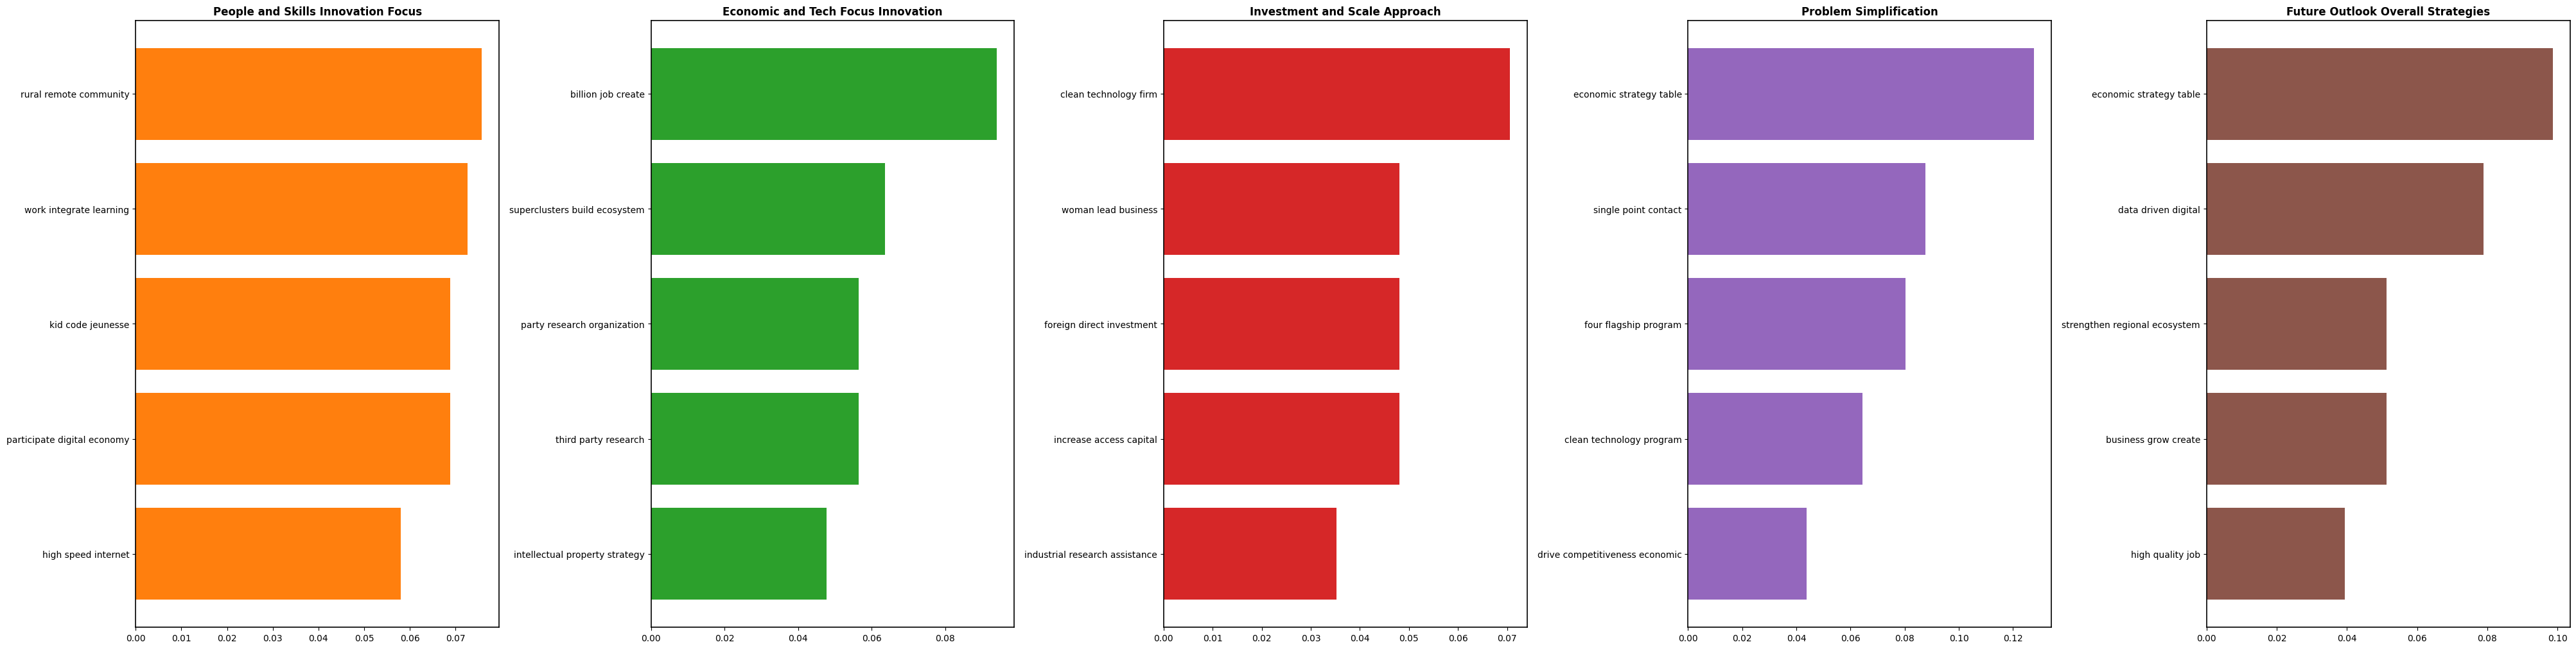

In [ ]:
#plotting the extracted kewyords

import matplotlib.pyplot as plt

def create_bar_plot_with_border(ax, df, title, color):
    ax.barh(df.iloc[:, 0], df.iloc[:, 1], color=color)
    ax.set_title(title, fontweight='bold', fontsize=12)
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(1.2)

    ax.invert_yaxis()

# Assuming peop_skill_fin, econ_tech_fin, inves_scale_fin, prob_simp_fin, and future_out_fin are defined elsewhere in your code.

fig, axs = plt.subplots(1, 5, figsize=(40, 10), constrained_layout=True) # Changed from 5, 1 to 1, 5
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

create_bar_plot_with_border(axs[0], peop_skill_fin, 'People and Skills Innovation Focus', colors[1])
create_bar_plot_with_border(axs[1], econ_tech_fin, 'Economic and Tech Focus Innovation', colors[2])
create_bar_plot_with_border(axs[2], inves_scale_fin, 'Investment and Scale Approach', colors[3])
create_bar_plot_with_border(axs[3], prob_simp_fin, 'Problem Simplification', colors[4])
create_bar_plot_with_border(axs[4], future_out_fin, 'Future Outlook Overall Strategies', colors[5])

plt.show()

# Newscrape and Data cleanup

In [ ]:
def news_getdf(keyword_search):
  fileName = str(keyword_search)+".csv" #initlaize filename
  words = fileName.split()
  no_whitespace = ''.join(words)
  keyword = keyword_search
  api_url = 'https://api.scrape-it.cloud/scrape/google'
  headers = {'x-api-key': Newscrape_API}
  #search parameters
  params = {
      'q': keyword,
      'domain': 'google.com',
      'tbm': 'nws',
      'num':100
  }
  response = requests.get(api_url, params=params, headers=headers) #API return
  data = response.json() #we only care about news data

  return data

#year_list = [2016,2017,2018,2019,2020,2021,2022,2023,2024]
#country_list = ["Canada", "USA", "Finland", "Japan", "Netherlands", "Singapore", "United Kingdom","Germany"]

#loop through country and year list #remember to change search topic
#if received keyerror that mean there is no news result on the topic, solution: change keyword search
#for country in country_list:
  #for year in year_list:
        #topic = str(country)+" "+"Graduate in Science and Engineering"+"Year:" + str(year)
        #file_name = str(country)+str(year)+" "+"Graduate in Science and Engineering"+".csv"
        #df_data = news_getdf(topic)
        #print(df_data)
        #news = df_data['newsResults']
        #df_news = pd.DataFrame(news)
        #df_news.to_csv(str(file_name))

#!zip -r /content/file.zip /content/ #zip the file for download


In [ ]:
#upload file
#df_2016 = pd.read_csv("/content/df_GERD_2016.csv")
#df_2017 = pd.read_csv("/content/df_GERD_2017.csv")
#df_2018 = pd.read_csv("/content/df_GERD_2018.csv")
#df_2019 = pd.read_csv("/content/df_GERD_2019.csv")
#df_2020 = pd.read_csv("/content/df_GERD_2020.csv")
#df_2021 = pd.read_csv("/content/df_GERD_2021.csv")
#df_2022 = pd.read_csv("/content/df_GERD_2022.csv")
#df_2023 = pd.read_csv("/content/df_GERD_2023.csv")
#combine relevatn data
#df_GERD = pd.concat([df_2016,df_2017,df_2018,df_2019,df_2020,df_2021,df_2022,df_2023],axis =0)
#drop duplicates
#df_GERD = df_GERD.drop_duplicates()
#save to CSV
#df_GERD.to_csv('GERD_cleaned.csv', index=False)

#df_STEM_2016 = pd.read_csv("/content/df_grad_Stem_2016.csv")
#df_STEM_2017 = pd.read_csv("/content/df_grad_Stem_2017.csv")
#df_STEM_2018 = pd.read_csv("/content/df_grad_Stem_2018.csv")
#df_STEM_2019 = pd.read_csv("/content/df_grad_Stem_2019.csv")
#df_STEM_2020 = pd.read_csv("/content/df_grad_Stem_2020.csv")
#df_STEM_2021 = pd.read_csv("/content/df_grad_Stem_2021.csv")
#df_STEM_2022 = pd.read_csv("/content/df_grad_Stem_2022.csv")
#df_STEM_2023 = pd.read_csv("/content/df_grad_Stem_2023.csv")
#df_STEM_2xxx = pd.read_csv("/content/df_grad_Stem.csv")
# Concatenate DataFrames
#df_STEM = pd.concat([df_STEM_2016,df_STEM_2017,df_STEM_2018,df_STEM_2019,df_STEM_2020,df_STEM_2021,df_STEM_2022,df_STEM_2023,df_STEM_2xxx],axis =0)
#drop duplicate and save
#df_STEM = df_STEM.drop_duplicates()
#df_STEM.to_csv('STEM_cleaned.csv', index=False)
#upload file
#df_2017 = pd.read_csv("/content/United States2017 GERD.csv")
#df_2018 = pd.read_csv("/content/United States2018 GERD.csv")
#df_2019 = pd.read_csv("/content/United States2019 GERD.csv")
#df_2020 = pd.read_csv("/content/United States2020 GERD.csv")
#df_2021 = pd.read_csv("/content/United States2021 GERD.csv")
#df_2022 = pd.read_csv("/content/United States2022 GERD.csv")
#df_2023 = pd.read_csv("/content/United States2023 GERD.csv")
#df_2024 = pd.read_csv("/content/United States2024 GERD.csv")
#df_xxxx = pd.read_csv("/content/United States GERD.csv")
#df = pd.concat([df_xxxx,df_2017,df_2018,df_2019,df_2020,df_2021,df_2022,df_2023,df_2024],axis =0)
#drop duplicate and save
#df = df.drop_duplicates()
#df.to_csv('GERD_US_cleaned.csv', index=False)
#upload file
#df_2017 = pd.read_csv("/content/Finland2017 GERD.csv")
#df_2018 = pd.read_csv("/content/Finland2018 GERD.csv")
#df_2019 = pd.read_csv("/content/Finland2019 GERD.csv")
#df_2020 = pd.read_csv("/content/Finland2020 GERD.csv")
#df_2021 = pd.read_csv("/content/Finland2021 GERD.csv")
#df_2022 = pd.read_csv("/content/Finland2022 GERD.csv")
#df_2023 = pd.read_csv("/content/Finland2023 GERD.csv")
#df_2024 = pd.read_csv("/content/Finland2024 GERD.csv")
#df = pd.concat([df_2017,df_2018,df_2019,df_2020,df_2021,df_2022,df_2023,df_2024],axis =0)
#df = df.drop_duplicates()
#df.to_csv('GERD_Finland_cleaned.csv', index=False)
#upload file
#df_2017 = pd.read_csv("/content/Germany2017 GERD.csv")
#df_2018 = pd.read_csv("/content/Germany2018 GERD.csv")
#df_2019 = pd.read_csv("/content/Germany2019 GERD.csv")
#df_2020 = pd.read_csv("/content/Germany2020 GERD.csv")
#df_2021 = pd.read_csv("/content/Germany2021 GERD.csv")
#df_2022 = pd.read_csv("/content/Germany2022 GERD.csv")
#df_2023 = pd.read_csv("/content/Germany2023 GERD.csv")
#df_2024 = pd.read_csv("/content/Germany2024 GERD.csv")

# Concatenate DataFrames
#df = pd.concat([df_2017, df_2018, df_2019, df_2020, df_2021, df_2022, df_2023, df_2024], axis=0)

# Drop duplicates
#df = df.drop_duplicates()

# Save to CSV
#df.to_csv('GERD_Germany_cleaned.csv', index=False)

# Read Japan's GERD data files
#df_2017 = pd.read_csv("/content/Japan2017 GERD.csv")
#df_2018 = pd.read_csv("/content/Japan2018 GERD.csv")
#df_2019 = pd.read_csv("/content/Japan2019 GERD.csv")
#df_2020 = pd.read_csv("/content/Japan2020 GERD.csv")
#df_2021 = pd.read_csv("/content/Japan2021 GERD.csv")
#df_2022 = pd.read_csv("/content/Japan2022 GERD.csv")
#df_2023 = pd.read_csv("/content/Japan2023 GERD.csv")
#df_2024 = pd.read_csv("/content/Japan2024 GERD.csv")

# Concatenate DataFrames
#df = pd.concat([df_2017, df_2018, df_2019, df_2020, df_2021, df_2022, df_2023, df_2024], axis=0)

# Drop duplicates
#df = df.drop_duplicates()

# Save to CSV
#df.to_csv('GERD_Japan_cleaned.csv', index=False)

# Read Netherlands' GERD data files
#df_2017 = pd.read_csv("/content/Netherlands2017 GERD.csv")
#df_2018 = pd.read_csv("/content/Netherlands2018 GERD.csv")
#df_2019 = pd.read_csv("/content/Netherlands2019 GERD.csv")
#df_2020 = pd.read_csv("/content/Netherlands2020 GERD.csv")
#df_2021 = pd.read_csv("/content/Netherlands2021 GERD.csv")
#df_2022 = pd.read_csv("/content/Netherlands2022 GERD.csv")
#df_2023 = pd.read_csv("/content/Netherlands2023 GERD.csv")
#df_2024 = pd.read_csv("/content/Netherlands2024 GERD.csv")

# Concatenate DataFrames
#df = pd.concat([df_2017, df_2018, df_2019, df_2020, df_2021, df_2022, df_2023, df_2024], axis=0)

# Drop duplicates
#df = df.drop_duplicates()

# Save to CSV
#df.to_csv('GERD_Netherlands_cleaned.csv', index=False)

# Read Singapore's GERD data files
#df_2017 = pd.read_csv("/content/Singapore2017 GERD.csv")
#df_2018 = pd.read_csv("/content/Singapore2018 GERD.csv")
#df_2019 = pd.read_csv("/content/Singapore2019 GERD.csv")
#df_2020 = pd.read_csv("/content/Singapore2020 GERD.csv")
#df_2021 = pd.read_csv("/content/Singapore2021 GERD.csv")
#df_2022 = pd.read_csv("/content/Singapore2022 GERD.csv")
#df_2023 = pd.read_csv("/content/Singapore2023 GERD.csv")
#df_2024 = pd.read_csv("/content/Singapore2024 GERD.csv")

# Concatenate DataFrames
#df = pd.concat([df_2017, df_2018, df_2019, df_2020, df_2021, df_2022, df_2023, df_2024], axis=0)

# Drop duplicates
#df = df.drop_duplicates()

# Save to CSV
#df.to_csv('GERD_Singapore_cleaned.csv', index=False)

# Read United Kingdom's GERD data files
#df_2017 = pd.read_csv("/content/United Kingdom2017 GERD.csv")
#df_2018 = pd.read_csv("/content/United Kingdom2018 GERD.csv")
#df_2019 = pd.read_csv("/content/United Kingdom2019 GERD.csv")
#df_2020 = pd.read_csv("/content/United Kingdom2020 GERD.csv")
#df_2021 = pd.read_csv("/content/United Kingdom2021 GERD.csv")
#df_2022 = pd.read_csv("/content/United Kingdom2022 GERD.csv")
#df_2023 = pd.read_csv("/content/United Kingdom2023 GERD.csv")
#df_2024 = pd.read_csv("/content/United Kingdom2024 GERD.csv")

# Concatenate DataFrames
#df = pd.concat([df_2017, df_2018, df_2019, df_2020, df_2021, df_2022, df_2023, df_2024], axis=0)

# Drop duplicates
#df = df.drop_duplicates()

# Save to CSV
#df.to_csv('GERD_UnitedKingdom_cleaned.csv', index=False)

# Read United Kingdom's GERD data files
#df_2017 = pd.read_csv("/content/Finland2017 Graduate in Science and Engineering.csv")
#df_2018 = pd.read_csv("/content/Finland2018 Graduate in Science and Engineering.csv")
#df_2019 = pd.read_csv("/content/Finland2019 Graduate in Science and Engineering.csv")
#df_2020 = pd.read_csv("/content/Finland2020 Graduate in Science and Engineering.csv")
#df_2021 = pd.read_csv("/content/Finland2021 Graduate in Science and Engineering.csv")
#df_2022 = pd.read_csv("/content/Finland2022 Graduate in Science and Engineering.csv")
#df_2023 = pd.read_csv("/content/Finland2023 Graduate in Science and Engineering.csv")
#df_2024 = pd.read_csv("/content/Finland2024 Graduate in Science and Engineering.csv")

# Concatenate DataFrames
#df = pd.concat([df_2017, df_2018, df_2019, df_2020, df_2021, df_2022, df_2023, df_2024], axis=0)

# Drop duplicates
#df = df.drop_duplicates()

# Save to CSV
#df.to_csv('STEM_Finland_cleaned.csv', index=False)

# Read Germany's GERD data files
#df_2017 = pd.read_csv("/content/Germany2017 Graduate in Science and Engineering.csv")
#df_2018 = pd.read_csv("/content/Germany2018 Graduate in Science and Engineering.csv")
#df_2019 = pd.read_csv("/content/Germany2019 Graduate in Science and Engineering.csv")
#df_2020 = pd.read_csv("/content/Germany2020 Graduate in Science and Engineering.csv")
#df_2021 = pd.read_csv("/content/Germany2021 Graduate in Science and Engineering.csv")
#df_2022 = pd.read_csv("/content/Germany2022 Graduate in Science and Engineering.csv")
#df_2023 = pd.read_csv("/content/Germany2023 Graduate in Science and Engineering.csv")
#df_2024 = pd.read_csv("/content/Germany2024 Graduate in Science and Engineering.csv")

# Concatenate DataFrames
#df = pd.concat([df_2017, df_2018, df_2019, df_2020, df_2021, df_2022, df_2023, df_2024], axis=0)

# Drop duplicates
#df = df.drop_duplicates()

# Save to CSV
#df.to_csv('STEM_Germany_cleaned.csv', index=False)

# Read Japan's GERD data files
#df_2017 = pd.read_csv("/content/Japan2017 Graduate in Science and Engineering.csv")
#df_2018 = pd.read_csv("/content/Japan2018 Graduate in Science and Engineering.csv")
#df_2019 = pd.read_csv("/content/Japan2019 Graduate in Science and Engineering.csv")
#df_2020 = pd.read_csv("/content/Japan2020 Graduate in Science and Engineering.csv")
#df_2021 = pd.read_csv("/content/Japan2021 Graduate in Science and Engineering.csv")
#df_2022 = pd.read_csv("/content/Japan2022 Graduate in Science and Engineering.csv")
#df_2023 = pd.read_csv("/content/Japan2023 Graduate in Science and Engineering.csv")
#df_2024 = pd.read_csv("/content/Japan2024 Graduate in Science and Engineering.csv")

# Concatenate DataFrames
#df = pd.concat([df_2017, df_2018, df_2019, df_2020, df_2021, df_2022, df_2023, df_2024], axis=0)

# Drop duplicates
#df = df.drop_duplicates()

# Save to CSV
#df.to_csv('STEM_Japan_cleaned.csv', index=False)

# Read Netherlands's GERD data files
#df_2017 = pd.read_csv("/content/Netherlands2017 Graduate in Science and Engineering.csv")
#df_2018 = pd.read_csv("/content/Netherlands2018 Graduate in Science and Engineering.csv")
#df_2019 = pd.read_csv("/content/Netherlands2019 Graduate in Science and Engineering.csv")
#df_2020 = pd.read_csv("/content/Netherlands2020 Graduate in Science and Engineering.csv")
#df_2021 = pd.read_csv("/content/Netherlands2021 Graduate in Science and Engineering.csv")
#f_2022 = pd.read_csv("/content/Netherlands2022 Graduate in Science and Engineering.csv")
#df_2023 = pd.read_csv("/content/Netherlands2023 Graduate in Science and Engineering.csv")
#df_2024 = pd.read_csv("/content/Netherlands2024 Graduate in Science and Engineering.csv")

# Concatenate DataFrames
#df = pd.concat([df_2017, df_2018, df_2019, df_2020, df_2021, df_2022, df_2023, df_2024], axis=0)

# Drop duplicates
#df = df.drop_duplicates()

# Save to CSV
#df.to_csv('STEM_Netherlands_cleaned.csv', index=False)

# Read Singapore's GERD data files
#df_2017 = pd.read_csv("/content/Singapore2017 Graduate in Science and Engineering.csv")
#df_2018 = pd.read_csv("/content/Singapore2018 Graduate in Science and Engineering.csv")
#df_2019 = pd.read_csv("/content/Singapore2019 Graduate in Science and Engineering.csv")
#df_2020 = pd.read_csv("/content/Singapore2020 Graduate in Science and Engineering.csv")
#df_2021 = pd.read_csv("/content/Singapore2021 Graduate in Science and Engineering.csv")
#df_2022 = pd.read_csv("/content/Singapore2022 Graduate in Science and Engineering.csv")
#df_2023 = pd.read_csv("/content/Singapore2023 Graduate in Science and Engineering.csv")
#df_2024 = pd.read_csv("/content/Singapore2024 Graduate in Science and Engineering.csv")

# Concatenate DataFrames
#df = pd.concat([df_2017, df_2018, df_2019, df_2020, df_2021, df_2022, df_2023, df_2024], axis=0)

# Drop duplicates
#df = df.drop_duplicates()

# Save to CSV
#df.to_csv('STEM_Singapore_cleaned.csv', index=False)

# Read United Kingdom's GERD data files
#df_2017 = pd.read_csv("/content/United Kingdom2017 Graduate in Science and Engineering.csv")
#df_2018 = pd.read_csv("/content/United Kingdom2018 Graduate in Science and Engineering.csv")
#df_2019 = pd.read_csv("/content/United Kingdom2019 Graduate in Science and Engineering.csv")
#df_2020 = pd.read_csv("/content/United Kingdom2020 Graduate in Science and Engineering.csv")
#df_2021 = pd.read_csv("/content/United Kingdom2021 Graduate in Science and Engineering.csv")
#df_2022 = pd.read_csv("/content/United Kingdom2022 Graduate in Science and Engineering.csv")
#df_2023 = pd.read_csv("/content/United Kingdom2023 Graduate in Science and Engineering.csv")
#df_2024 = pd.read_csv("/content/United Kingdom2024 Graduate in Science and Engineering.csv")

# Concatenate DataFrames
#df = pd.concat([df_2017, df_2018, df_2019, df_2020, df_2021, df_2022, df_2023, df_2024], axis=0)

# Drop duplicates
#df = df.drop_duplicates()

# Save to CSV
#df.to_csv('STEM_UnitedKingdom_cleaned.csv', index=False)

# Read United States' GERD data files
#df_2017 = pd.read_csv("/content/United States2017 Graduate in Science and Engineering.csv")
#df_2018 = pd.read_csv("/content/United States2018 Graduate in Science and Engineering.csv")
#df_2019 = pd.read_csv("/content/United States2019 Graduate in Science and Engineering.csv")
#df_2020 = pd.read_csv("/content/United States2020 Graduate in Science and Engineering.csv")
#df_2021 = pd.read_csv("/content/United States2021 Graduate in Science and Engineering.csv")
#df_2022 = pd.read_csv("/content/United States2022 Graduate in Science and Engineering.csv")
#df_2023 = pd.read_csv("/content/United States2023 Graduate in Science and Engineering.csv")
#df_2024 = pd.read_csv("/content/United States2024 Graduate in Science and Engineering.csv")

# Concatenate DataFrames
#df = pd.concat([df_2017, df_2018, df_2019, df_2020, df_2021, df_2022, df_2023, df_2024], axis=0)

# Drop duplicates
#df = df.drop_duplicates()

# Save to CSV
#df.to_csv('STEM_UnitedStates_cleaned.csv', index=False)

# Sentimental Analysis Canada vs Other countries

In [ ]:
def sentiment(text_string):
  text_string = TextBlob(text_string) #initlizate textblob object
  polar = text_string.sentiment.polarity #polarity
  subject = text_string.sentiment.subjectivity #subjectivity
  return(polar,subject)

def full_sentiment(df):

  list_title_snippet =[]
  for i in range(df.shape[0]):
    df["date"].iloc[i] = datetime.strptime(df["date"].iloc[i], "%b %d, %Y").year #clean up date
    title_snippet = str(df["title"].iloc[i])+" "+str(df["snippet"].iloc[i]) #combined title and snippet
    list_title_snippet.append(title_snippet)
  df = pd.concat([df,pd.DataFrame(list_title_snippet, columns = ["Title+snippet"])],axis =1) #prepare text
  #initlize empty array tos tore value
  polar_list =[]
  subject_list = []
  for i in range(df.shape[0]):#loop through to perform sentimental analysis
    polar_value,subject_value = sentiment(str(df["Title+snippet"].iloc[i]))
    polar_list.append(polar_value) #collect result
    subject_list.append(subject_value)
  df = pd.concat([df,pd.DataFrame(polar_list, columns = ["Polarity"]),pd.DataFrame(subject_list, columns = ["Subjectivity"])],axis =1) #create resutl dataframe
  return(df)
#same function but different date time format due to inconsistency in API result
def full_sentiment_2(df):

  list_title_snippet =[]
  for i in range(df.shape[0]):
    df["date"].iloc[i] = datetime.strptime(df["date"].iloc[i], "%d-%b-%y").year #different time date format
    title_snippet = str(df["title"].iloc[i])+" "+str(df["snippet"].iloc[i])
    list_title_snippet.append(title_snippet)
  df = pd.concat([df,pd.DataFrame(list_title_snippet, columns = ["Title+snippet"])],axis =1)
  polar_list =[]
  subject_list = []
  for i in range(df.shape[0]):
    polar_value,subject_value = sentiment(str(df["Title+snippet"].iloc[i]))
    polar_list.append(polar_value)
    subject_list.append(subject_value)
  df = pd.concat([df,pd.DataFrame(polar_list, columns = ["Polarity"]),pd.DataFrame(subject_list, columns = ["Subjectivity"])],axis =1)
  return(df)

<ipython-input-73-7c4ba4543389>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["date"].iloc[i] = datetime.strptime(df["date"].iloc[i], "%b %d, %Y").year #clean up date
<ipython-input-73-7c4ba4543389>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["date"].iloc[i] = datetime.strptime(df["date"].iloc[i], "%d-%b-%y").year #different time date format


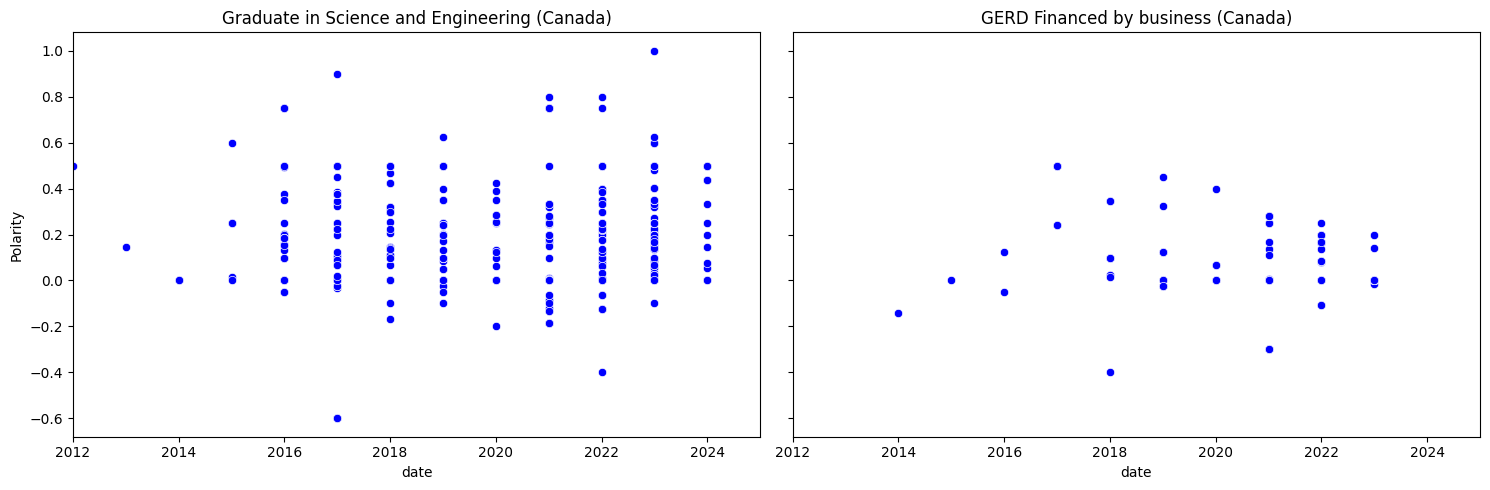

In [ ]:
# Read cleaned data for Canada GERD and STEM
df_CANADA_GERD = pd.read_csv('/content/GERD_Canada_cleaned.csv')
df_CANADA_STEM = pd.read_csv('/content/STEM_Canada_cleaned.csv')

# Apply sentiment analysis to Canada GERD and STEM data
df_CANADA_GERD = full_sentiment(df_CANADA_GERD)
df_CANADA_STEM = full_sentiment_2(df_CANADA_STEM)

# Create subplots
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5), sharex=True, sharey=True)

# Scatter plot and average line for Graduate in Science and Engineering (Canada)
sns.scatterplot(data=df_CANADA_STEM, x='date', y='Polarity', color='blue', ax=ax1)

# Scatter plot for GERD Financed by business (Canada)
sns.scatterplot(data=df_CANADA_GERD, x='date', y='Polarity', color='blue', ax=ax2)

# Set titles for subplots
ax1.set_title('Graduate in Science and Engineering (Canada)')
ax2.set_title('GERD Financed by business (Canada)')

# Adjust layout
plt.xlim(2012,2025)
plt.tight_layout()
plt.show()

<ipython-input-73-7c4ba4543389>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["date"].iloc[i] = datetime.strptime(df["date"].iloc[i], "%d-%b-%y").year #different time date format
<ipython-input-73-7c4ba4543389>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["date"].iloc[i] = datetime.strptime(df["date"].iloc[i], "%d-%b-%y").year #different time date format


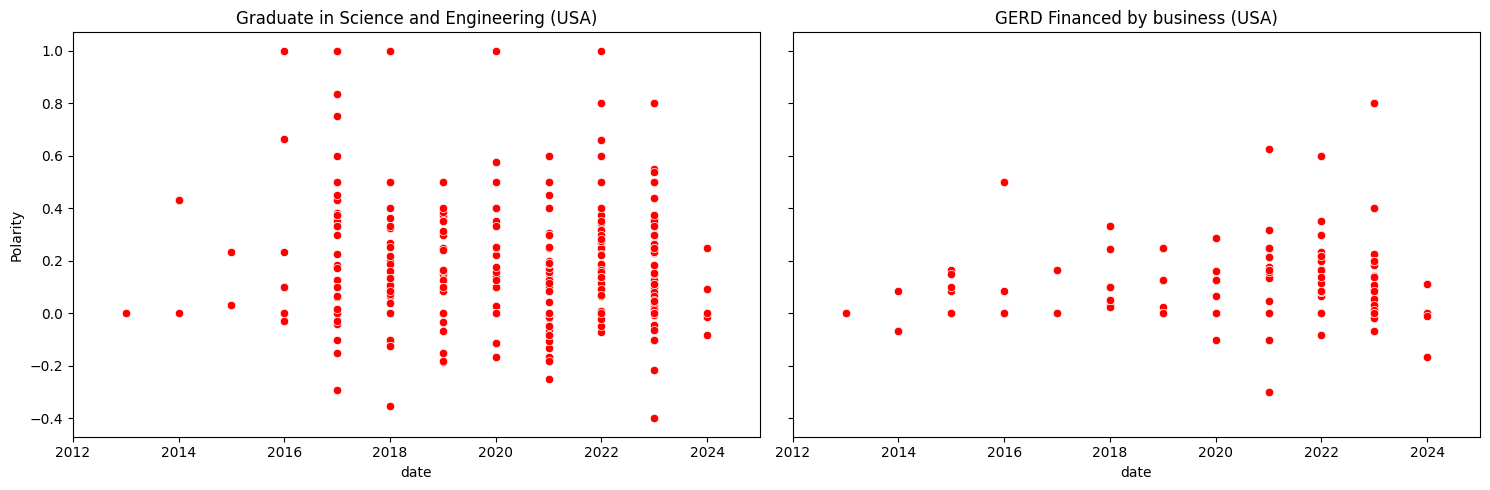

In [ ]:
# Read cleaned data for United States GERD and STEM
df_US_GERD = pd.read_csv('/content/GERD_US_cleaned.csv')
df_US_STEM = pd.read_csv('/content/STEM_UnitedStates_cleaned.csv')

# Apply sentiment analysis to United States GERD and STEM data
df_US_GERD = full_sentiment_2(df_US_GERD)
df_US_STEM = full_sentiment_2(df_US_STEM)

# Create subplots
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5), sharex=True, sharey=True)

# Scatter plot and average line for Graduate in Science and Engineering
sns.scatterplot(data=df_US_STEM, x='date', y='Polarity', color='red', ax=ax1)


# Scatter plot for GERD Financed by business
sns.scatterplot(data=df_US_GERD, x='date', y='Polarity', color='red', ax=ax2)

# Set titles for subplots
ax1.set_title('Graduate in Science and Engineering (USA)')
ax2.set_title('GERD Financed by business (USA)')

# Adjust layout
plt.xlim(2012,2025)
plt.tight_layout()
plt.show()


<ipython-input-73-7c4ba4543389>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["date"].iloc[i] = datetime.strptime(df["date"].iloc[i], "%b %d, %Y").year #clean up date
<ipython-input-73-7c4ba4543389>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["date"].iloc[i] = datetime.strptime(df["date"].iloc[i], "%d-%b-%y").year #different time date format


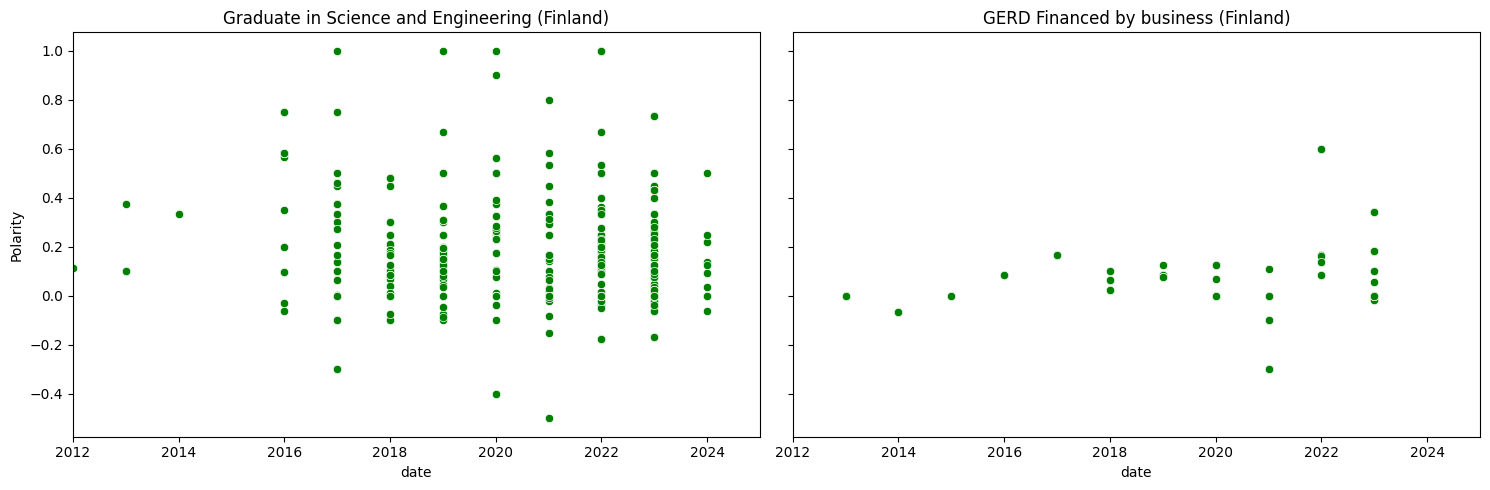

In [ ]:
# Read cleaned data for Finland's GERD and STEM
df_FINLAND_GERD = pd.read_csv('/content/GERD_Finland_cleaned.csv')
df_FINLAND_STEM = pd.read_csv('/content/STEM_Finland_cleaned.csv')

# Apply sentiment analysis to Finland's GERD and STEM data
df_FINLAND_GERD = full_sentiment(df_FINLAND_GERD)
df_FINLAND_STEM = full_sentiment_2(df_FINLAND_STEM)

# Create subplots
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5), sharex=True, sharey=True)

# Scatter plot and average line for Graduate in Science and Engineering (Finland)
sns.scatterplot(data=df_FINLAND_STEM, x='date', y='Polarity', color='green', ax=ax1)

# Scatter plot for GERD Financed by business (Finland)
sns.scatterplot(data=df_FINLAND_GERD, x='date', y='Polarity', color='green', ax=ax2)

# Set titles for subplots
ax1.set_title('Graduate in Science and Engineering (Finland)')
ax2.set_title('GERD Financed by business (Finland)')

# Adjust layout
plt.xlim(2012,2025)
plt.tight_layout()
plt.show()

<ipython-input-73-7c4ba4543389>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["date"].iloc[i] = datetime.strptime(df["date"].iloc[i], "%d-%b-%y").year #different time date format
<ipython-input-73-7c4ba4543389>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["date"].iloc[i] = datetime.strptime(df["date"].iloc[i], "%d-%b-%y").year #different time date format


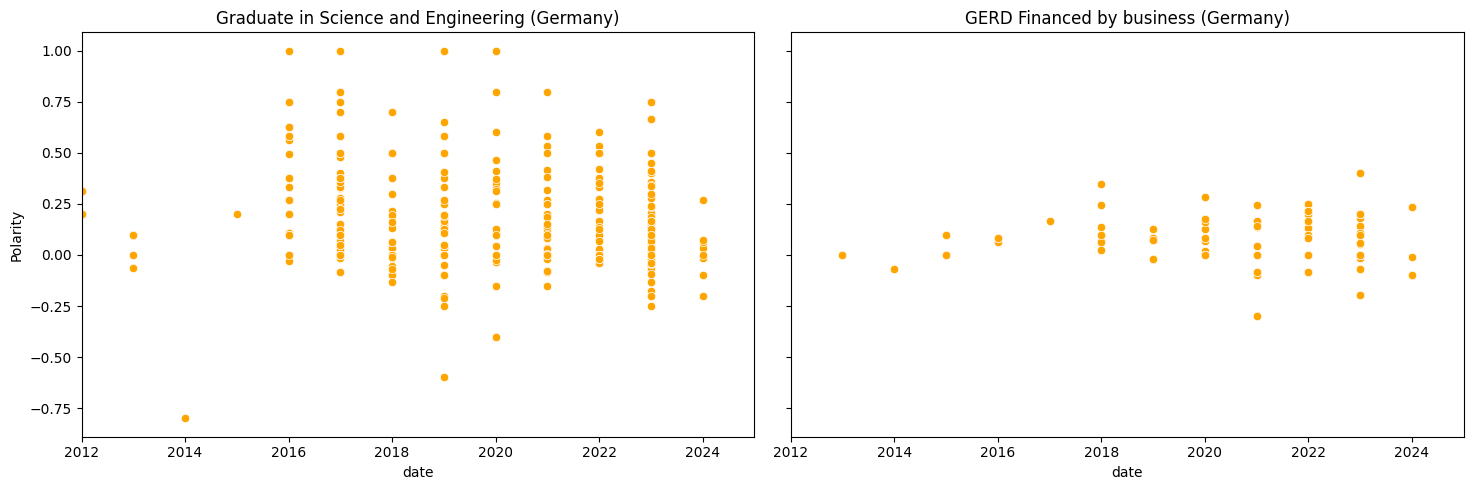

In [ ]:
# Read cleaned data for Germany GERD
df_GERMANY_GERD = pd.read_csv('/content/GERD_Germany_cleaned.csv')
df_GERMANY_STEM = pd.read_csv('/content/STEM_Germany_cleaned.csv')
# Apply sentiment analysis
df_GERMANY_GERD = full_sentiment_2(df_GERMANY_GERD)
df_GERMANY_STEM = full_sentiment_2(df_GERMANY_STEM)

# Create subplots
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5), sharex=True, sharey=True)

# Scatter plot and average line for Graduate in Science and Engineering
sns.scatterplot(data=df_GERMANY_STEM, x='date', y='Polarity', color='orange', ax=ax1)

ax1.set_title('Graduate in Science and Engineering (Germany)')

# Scatter plot for GERD Financed by business
sns.scatterplot(data=df_GERMANY_GERD, x='date', y='Polarity', color='orange', ax=ax2)
ax2.set_title('GERD Financed by business (Germany)')

plt.tight_layout()
plt.xlim(2012,2025)
plt.show()

<ipython-input-73-7c4ba4543389>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["date"].iloc[i] = datetime.strptime(df["date"].iloc[i], "%d-%b-%y").year #different time date format
<ipython-input-73-7c4ba4543389>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["date"].iloc[i] = datetime.strptime(df["date"].iloc[i], "%d-%b-%y").year #different time date format


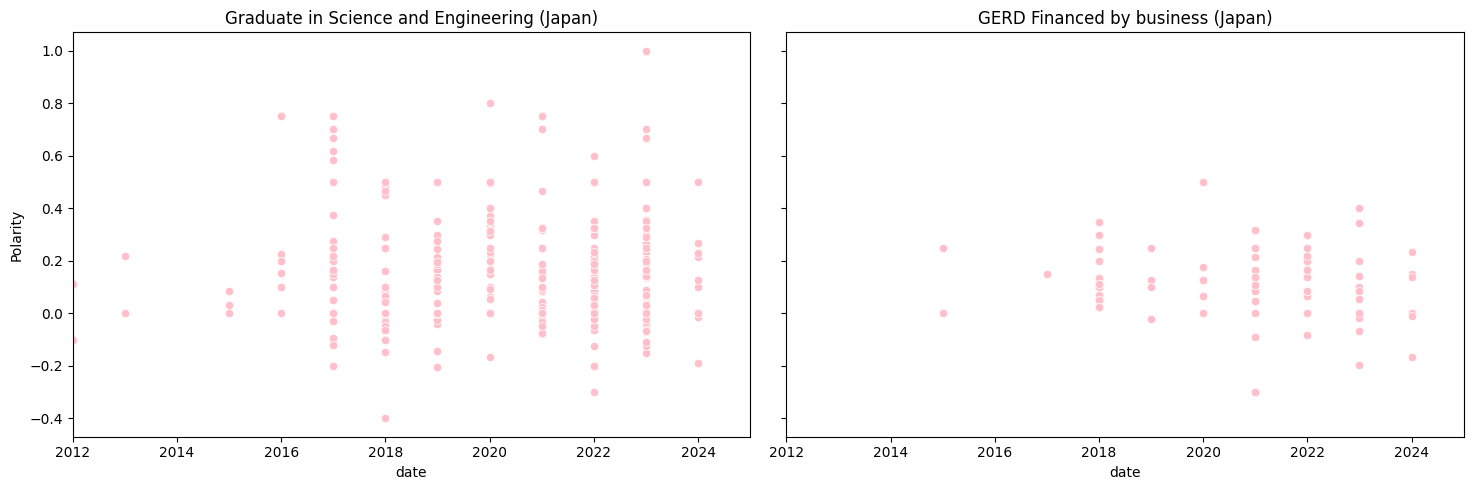

In [ ]:
df_JAPAN_GERD = pd.read_csv('/content/GERD_Japan_cleaned.csv')
df_JAPAN_STEM = pd.read_csv('/content/STEM_Japan_cleaned.csv')
# Apply sentiment analysis
df_JAPAN_GERD = full_sentiment_2(df_JAPAN_GERD)
df_JAPAN_STEM = full_sentiment_2(df_JAPAN_STEM)

# Create subplots
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5), sharex=True, sharey=True)

# Scatter plot and average line for Graduate in Science and Engineering
sns.scatterplot(data=df_JAPAN_STEM, x='date', y='Polarity', color='pink', ax=ax1)
ax1.set_title('Graduate in Science and Engineering (Japan)')

# Scatter plot for GERD Financed by business
sns.scatterplot(data=df_JAPAN_GERD, x='date', y='Polarity', color='pink', ax=ax2)
ax2.set_title('GERD Financed by business (Japan)')

plt.tight_layout()
plt.xlim(2012,2025)

plt.show()

<ipython-input-73-7c4ba4543389>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["date"].iloc[i] = datetime.strptime(df["date"].iloc[i], "%d-%b-%y").year #different time date format
<ipython-input-73-7c4ba4543389>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["date"].iloc[i] = datetime.strptime(df["date"].iloc[i], "%d-%b-%y").year #different time date format


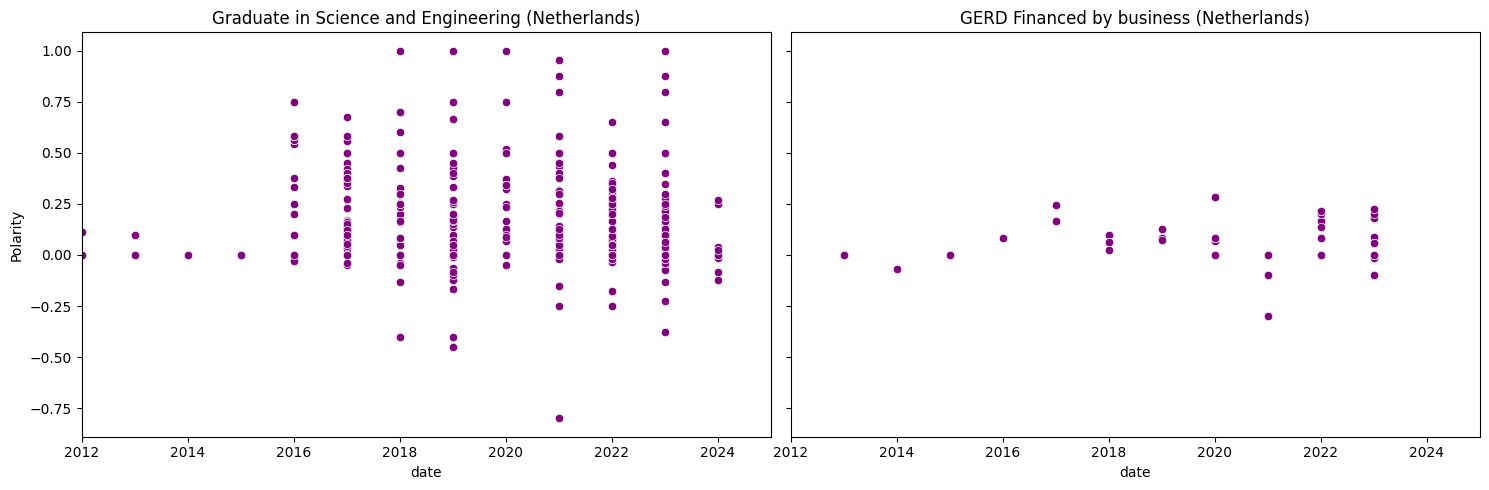

In [ ]:
# Read cleaned data for Netherlands GERD
df_NETHERLANDS_GERD = pd.read_csv('/content/GERD_Netherlands_cleaned.csv')
df_NETHERLANDS_STEM = pd.read_csv('/content/STEM_Netherlands_cleaned.csv')


# Apply sentiment analysis
df_NETHERLANDS_GERD = full_sentiment_2(df_NETHERLANDS_GERD)
df_NETHERLANDS_STEM = full_sentiment_2(df_NETHERLANDS_STEM)
# Create subplots
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5), sharex=True, sharey=True)

# Scatter plot and average line for Graduate in Science and Engineering
sns.scatterplot(data=df_NETHERLANDS_STEM, x='date', y='Polarity', color='purple', ax=ax1)
ax1.set_title('Graduate in Science and Engineering (Netherlands)')

# Scatter plot for GERD Financed by business
sns.scatterplot(data=df_NETHERLANDS_GERD, x='date', y='Polarity', color='purple', ax=ax2)
ax2.set_title('GERD Financed by business (Netherlands)')

plt.tight_layout()
plt.xlim(2012,2025)

plt.show()

<ipython-input-73-7c4ba4543389>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["date"].iloc[i] = datetime.strptime(df["date"].iloc[i], "%d-%b-%y").year #different time date format
<ipython-input-73-7c4ba4543389>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["date"].iloc[i] = datetime.strptime(df["date"].iloc[i], "%d-%b-%y").year #different time date format


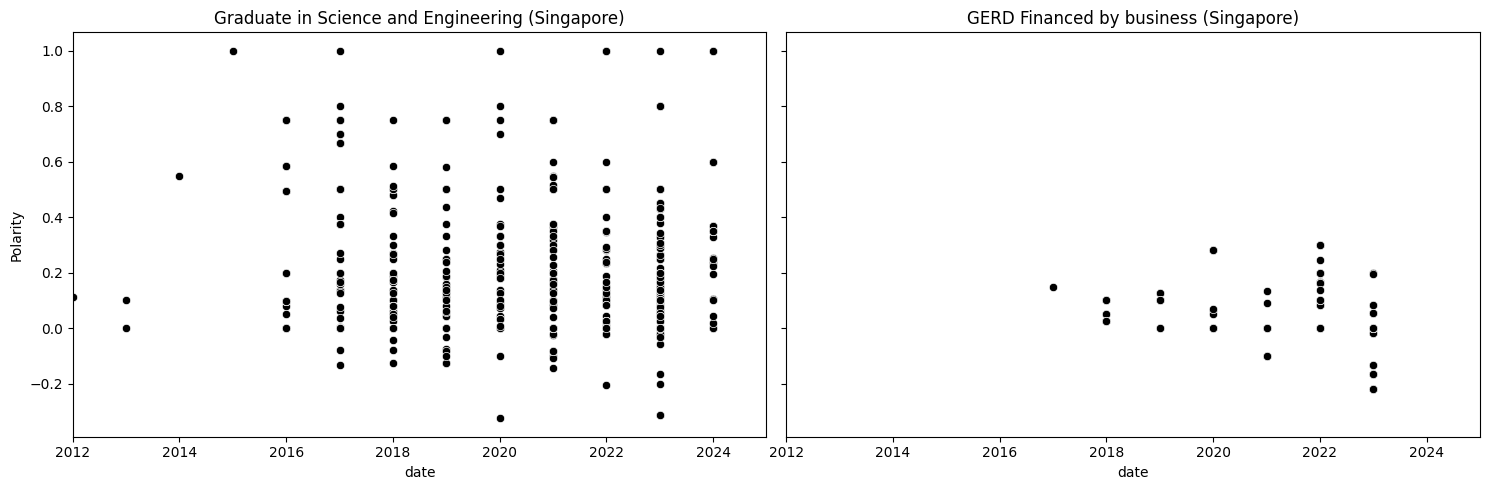

In [ ]:
# Read cleaned data for Singapore GERD
df_SINGAPORE_GERD = pd.read_csv('/content/GERD_Singapore_cleaned.csv')
df_SINGAPORE_STEM = pd.read_csv('/content/STEM_Singapore_cleaned.csv')

# Apply sentiment analysis
df_SINGAPORE_GERD = full_sentiment_2(df_SINGAPORE_GERD)
df_SINGAPORE_STEM = full_sentiment_2(df_SINGAPORE_STEM)

# Create subplots
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5), sharex=True, sharey=True)

# Scatter plot and average line for Graduate in Science and Engineering
sns.scatterplot(data=df_SINGAPORE_STEM, x='date', y='Polarity', color='black', ax=ax1)

ax1.set_title('Graduate in Science and Engineering (Singapore)')

# Scatter plot for GERD Financed by business
sns.scatterplot(data=df_SINGAPORE_GERD, x='date', y='Polarity', color='black', ax=ax2)
ax2.set_title('GERD Financed by business (Singapore)')

plt.tight_layout()
plt.xlim(2012,2025)

plt.show()

<ipython-input-73-7c4ba4543389>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["date"].iloc[i] = datetime.strptime(df["date"].iloc[i], "%d-%b-%y").year #different time date format
<ipython-input-73-7c4ba4543389>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["date"].iloc[i] = datetime.strptime(df["date"].iloc[i], "%d-%b-%y").year #different time date format


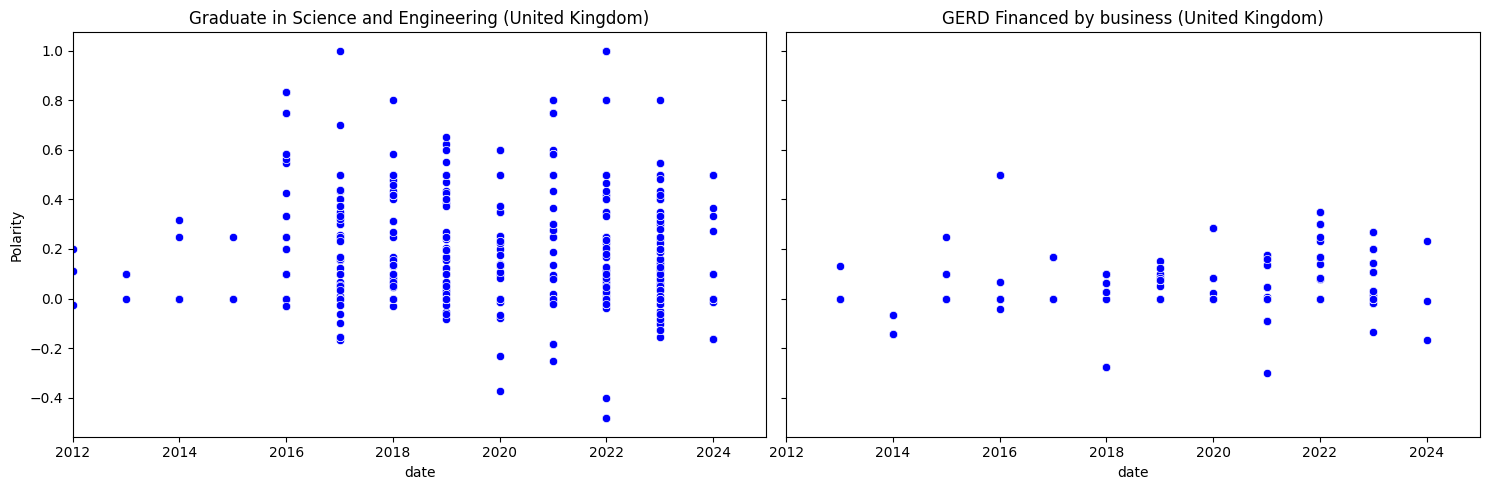

In [ ]:
# Read cleaned data for United Kingdom GERD
df_UK_GERD = pd.read_csv('/content/GERD_UnitedKingdom_cleaned.csv')
df_UK_STEM = pd.read_csv('/content/STEM_UnitedKingdom_cleaned.csv')

# Apply sentiment analysis
df_UK_GERD = full_sentiment_2(df_UK_GERD)
df_UK_STEM = full_sentiment_2(df_UK_STEM)
# Create subplots
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5), sharex=True, sharey=True)

# Scatter plot and average line for Graduate in Science and Engineering
sns.scatterplot(data=df_UK_STEM, x='date', y='Polarity', color='blue', ax=ax1)
ax1.set_title('Graduate in Science and Engineering (United Kingdom)')

# Scatter plot for GERD Financed by business
sns.scatterplot(data=df_UK_GERD, x='date', y='Polarity', color='blue', ax=ax2)
ax2.set_title('GERD Financed by business (United Kingdom)')

plt.tight_layout()
plt.xlim(2012,2025)

plt.show()

<ipython-input-82-fe05b15b26ab>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avg_canada_STEM = df_CANADA_STEM.groupby('date').mean()['Polarity']
<ipython-input-82-fe05b15b26ab>:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avg_UK_STEM = df_UK_STEM.groupby('date').mean()['Polarity']
<ipython-input-82-fe05b15b26ab>:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avg_US_STEM = df_US_STEM.groupby('date').mean()['P

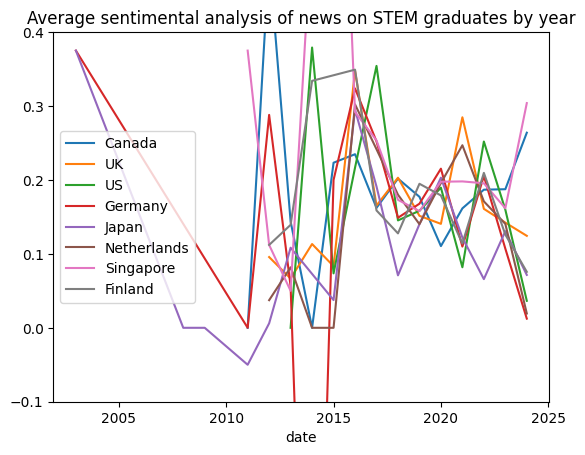

In [ ]:
#take the data then calculate average and plot
avg_canada_STEM = df_CANADA_STEM.groupby('date').mean()['Polarity']
avg_canada_STEM.plot(label = "Canada")
avg_UK_STEM = df_UK_STEM.groupby('date').mean()['Polarity']
avg_UK_STEM.plot(label = "UK")
avg_US_STEM = df_US_STEM.groupby('date').mean()['Polarity']
avg_US_STEM.plot(label="US")
avg_GERMANY_STEM = df_GERMANY_STEM.groupby('date').mean()['Polarity']
avg_GERMANY_STEM.plot(label="Germany")
avg_JAPAN_STEM = df_JAPAN_STEM.groupby('date').mean()['Polarity']
avg_JAPAN_STEM.plot(label="Japan")
avg_NETHERLANDS_STEM = df_NETHERLANDS_STEM.groupby('date').mean()['Polarity']
avg_NETHERLANDS_STEM.plot(label="Netherlands")
avg_SINGAPORE_STEM = df_SINGAPORE_STEM.groupby('date').mean()['Polarity']
avg_SINGAPORE_STEM.plot(label="Singapore")
avg_FINLAND_STEM = df_FINLAND_STEM.groupby('date').mean()['Polarity']
avg_FINLAND_STEM.plot(label="Finland")
plt.title("Average sentimental analysis of news on STEM graduates by year")
plt.ylim(-0.1, 0.4)
plt.legend()
plt.show()

<ipython-input-83-dde7f601a28c>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avg_canada_GERD = df_CANADA_GERD.groupby('date').mean()['Polarity']
<ipython-input-83-dde7f601a28c>:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avg_UK_GERD = df_UK_GERD.groupby('date').mean()['Polarity']
<ipython-input-83-dde7f601a28c>:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avg_US_GERD = df_US_GERD.groupby('date').mean()['P

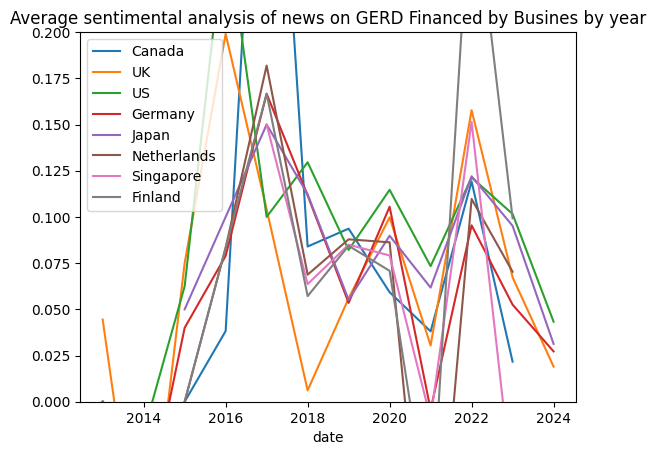

In [ ]:
#take the data then calculate average and plot
avg_canada_GERD = df_CANADA_GERD.groupby('date').mean()['Polarity']
avg_canada_GERD.plot(label = "Canada")
avg_UK_GERD = df_UK_GERD.groupby('date').mean()['Polarity']
avg_UK_GERD.plot(label = "UK")
avg_US_GERD = df_US_GERD.groupby('date').mean()['Polarity']
avg_US_GERD.plot(label="US")
avg_GERMANY_GERD = df_GERMANY_GERD.groupby('date').mean()['Polarity']
avg_GERMANY_GERD.plot(label="Germany")
avg_JAPAN_GERD = df_JAPAN_GERD.groupby('date').mean()['Polarity']
avg_JAPAN_GERD.plot(label="Japan")
avg_NETHERLANDS_GERD = df_NETHERLANDS_GERD.groupby('date').mean()['Polarity']
avg_NETHERLANDS_GERD.plot(label="Netherlands")
avg_SINGAPORE_GERD = df_SINGAPORE_GERD.groupby('date').mean()['Polarity']
avg_SINGAPORE_GERD.plot(label="Singapore")
avg_FINLAND_GERD = df_FINLAND_GERD.groupby('date').mean()['Polarity']
avg_FINLAND_GERD.plot(label="Finland")
plt.title("Average sentimental analysis of news on GERD Financed by Busines by year")
plt.ylim(0, 0.2)
plt.legend()
plt.show()

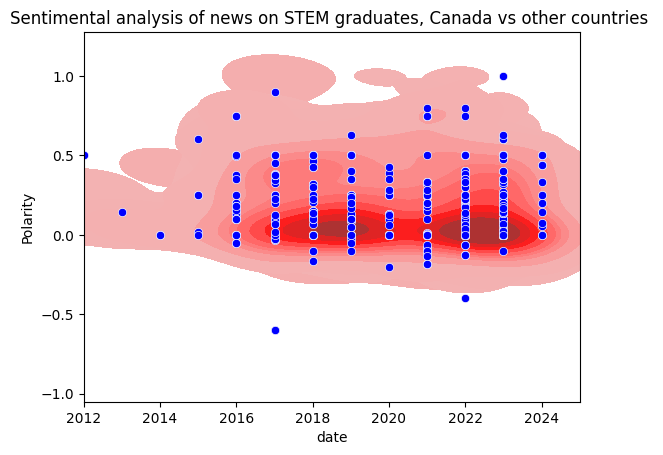

In [ ]:
#heat map plot STEM education
sns.kdeplot(data=df_US_STEM, x='date', y='Polarity', color='red', fill =True)
sns.kdeplot(data=df_FINLAND_STEM, x='date', y='Polarity', color='red', fill =True)
sns.kdeplot(data=df_GERMANY_STEM, x='date', y='Polarity', color='red', fill =True)
sns.kdeplot(data=df_JAPAN_STEM, x='date', y='Polarity', color='red', fill =True)
sns.kdeplot(data=df_SINGAPORE_STEM, x='date', y='Polarity', color='red', fill =True)
sns.kdeplot(data=df_NETHERLANDS_STEM, x='date', y='Polarity', color='red', fill =True)
sns.kdeplot(data=df_UK_STEM, x='date', y='Polarity', color='red', fill =True)
sns.scatterplot(data=df_CANADA_STEM, x='date', y='Polarity', color='blue')
plt.title("Sentimental analysis of news on STEM graduates, Canada vs other countries ")
plt.xlim(2012,2025)
plt.show()

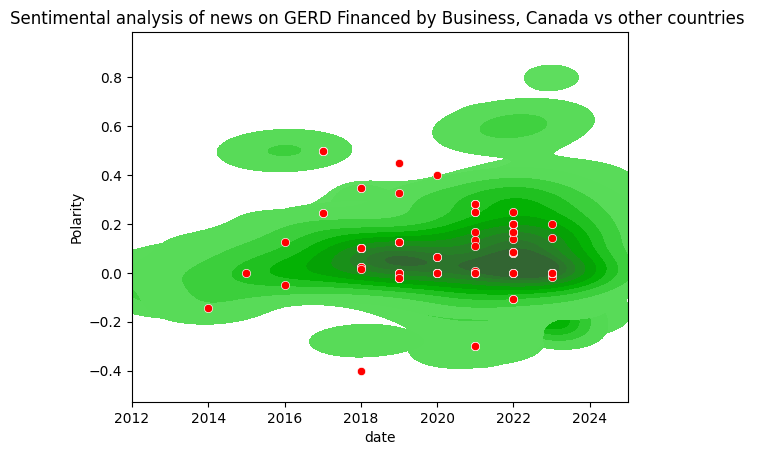

In [ ]:
#heat map plot GERD
sns.kdeplot(data=df_US_GERD, x='date', y='Polarity', color='green', fill = True)
sns.kdeplot(data=df_GERMANY_GERD, x='date', y='Polarity', color='green', fill = True)
sns.kdeplot(data=df_JAPAN_GERD, x='date', y='Polarity', color='green', fill = True)
sns.kdeplot(data=df_SINGAPORE_GERD, x='date', y='Polarity', color='green', fill = True)
sns.kdeplot(data=df_NETHERLANDS_GERD, x='date', y='Polarity', color='green', fill = True)
sns.kdeplot(data=df_FINLAND_GERD, x='date', y='Polarity', color='green', fill = True)
sns.kdeplot(data=df_UK_GERD, x='date', y='Polarity', color='green', fill = True)

sns.scatterplot(data=df_CANADA_GERD, x='date', y='Polarity', color='red')
plt.title("Sentimental analysis of news on GERD Financed by Business, Canada vs other countries ")

plt.xlim(2012,2025)
plt.show()

# Canada sentimental analysis

<ipython-input-73-7c4ba4543389>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["date"].iloc[i] = datetime.strptime(df["date"].iloc[i], "%d-%b-%y").year #different time date format
<ipython-input-73-7c4ba4543389>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["date"].iloc[i] = datetime.strptime(df["date"].iloc[i], "%d-%b-%y").year #different time date format


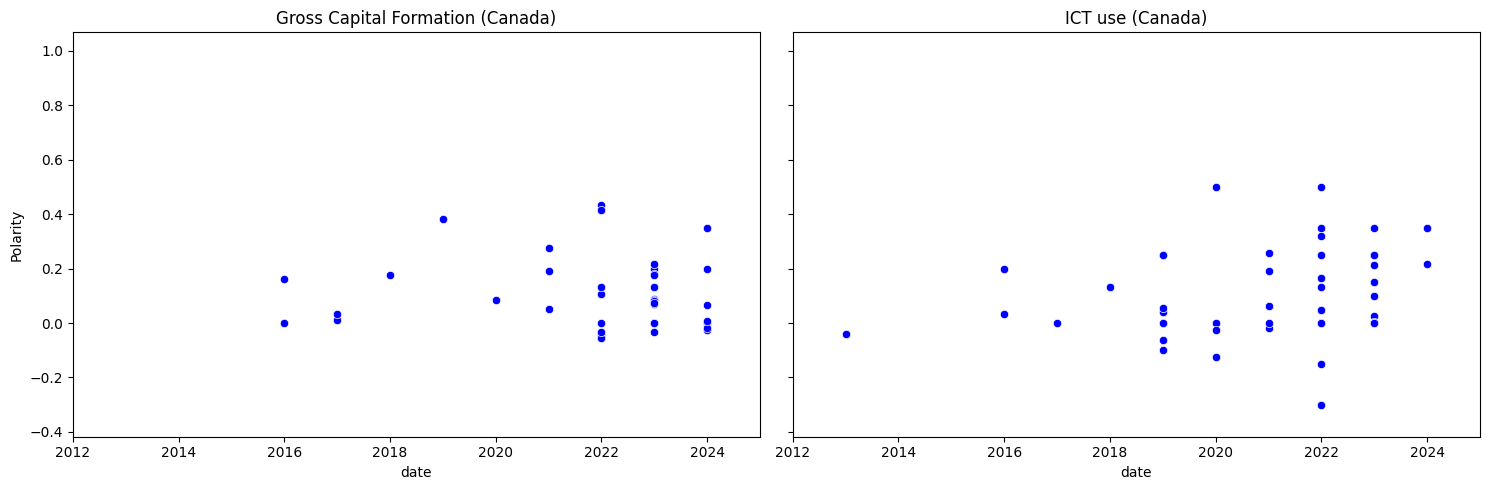

In [ ]:
# Read cleaned data for Canada GERD and STEM
df_CANADA_CanadaGrosscapitalformation = pd.read_csv('/content/CanadaGrosscapitalformation.csv')
df_CANADA_CanadaICTuse = pd.read_csv('/content/CanadaICTuse.csv')

# Apply sentiment analysis to Canada GERD and STEM data
df_CANADA_CanadaGrosscapitalformation = full_sentiment_2(df_CANADA_CanadaGrosscapitalformation)
df_CANADA_CanadaICTuse = full_sentiment_2(df_CANADA_CanadaICTuse)

# Create subplots
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5), sharex=True, sharey=True)

# Scatter plot and average line for Graduate in Science and Engineering (Canada)
sns.scatterplot(data=df_CANADA_CanadaGrosscapitalformation, x='date', y='Polarity', color='blue', ax=ax1)

# Scatter plot for GERD Financed by business (Canada)
sns.scatterplot(data=df_CANADA_CanadaICTuse, x='date', y='Polarity', color='blue', ax=ax2)

# Set titles for subplots
ax1.set_title('Gross Capital Formation (Canada)')
ax2.set_title('ICT use (Canada)')

# Adjust layout
plt.xlim(2012,2025)
plt.tight_layout()
plt.show()

<ipython-input-73-7c4ba4543389>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["date"].iloc[i] = datetime.strptime(df["date"].iloc[i], "%d-%b-%y").year #different time date format
<ipython-input-73-7c4ba4543389>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["date"].iloc[i] = datetime.strptime(df["date"].iloc[i], "%d-%b-%y").year #different time date format


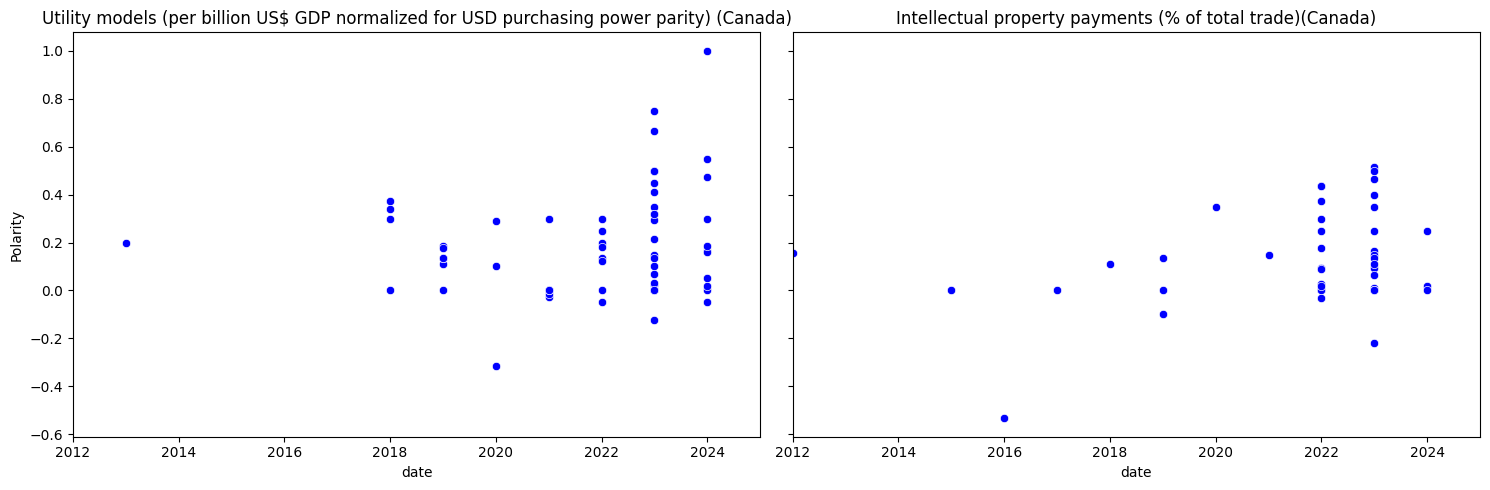

In [ ]:
# Read cleaned data for Canada GERD and STEM
df_CANADA_CanadaCanadaUtilitymodel = pd.read_csv('/content/CanadaUtilitymodel.csv')
df_CANADA_canadaintellectualpropertypayment = pd.read_csv('/content/canadaintellectualpropertypayment.csv')

# Apply sentiment analysis to Canada GERD and STEM data
df_CANADA_CanadaCanadaUtilitymodel = full_sentiment_2(df_CANADA_CanadaCanadaUtilitymodel)
df_CANADA_canadaintellectualpropertypayment = full_sentiment_2(df_CANADA_canadaintellectualpropertypayment)

# Create subplots
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5), sharex=True, sharey=True)

# Scatter plot and average line for Graduate in Science and Engineering (Canada)
sns.scatterplot(data=df_CANADA_CanadaCanadaUtilitymodel, x='date', y='Polarity', color='blue', ax=ax1)

# Scatter plot for GERD Financed by business (Canada)
sns.scatterplot(data=df_CANADA_canadaintellectualpropertypayment, x='date', y='Polarity', color='blue', ax=ax2)

# Set titles for subplots
ax1.set_title('Utility models (per billion US$ GDP normalized for USD purchasing power parity) (Canada)')
ax2.set_title('Intellectual property payments (% of total trade)(Canada)')

# Adjust layout
plt.xlim(2012,2025)
plt.tight_layout()
plt.show()

<ipython-input-73-7c4ba4543389>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["date"].iloc[i] = datetime.strptime(df["date"].iloc[i], "%d-%b-%y").year #different time date format
<ipython-input-73-7c4ba4543389>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["date"].iloc[i] = datetime.strptime(df["date"].iloc[i], "%d-%b-%y").year #different time date format
<ipython-input-73-7c4ba4543389>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

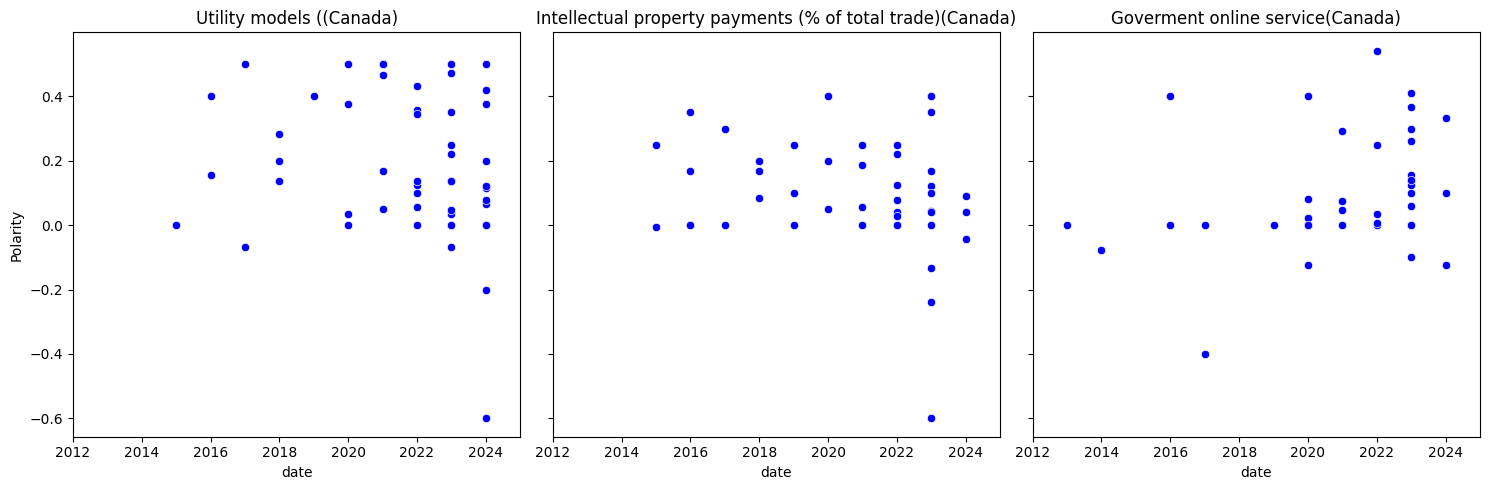

In [ ]:
# Read cleaned data for Canada GERD and STEM
df_CANADA_candaEparticipation = pd.read_csv('/content/candaEparticipation.csv')
df_CANADA_candaregualtoryindex = pd.read_csv('/content/candaregualtoryindex.csv')
df_CANADA_govermentonlineservicecanada = pd.read_csv('/content/govermentonlineservicecanada.csv')


# Apply sentiment analysis to Canada GERD and STEM data
df_CANADA_candaEparticipation = full_sentiment_2(df_CANADA_candaEparticipation)
df_CANADA_candaregualtoryindex = full_sentiment_2(df_CANADA_candaregualtoryindex)
df_CANADA_govermentonlineservicecanada = full_sentiment_2(df_CANADA_govermentonlineservicecanada)


# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15, 5), sharex=True, sharey=True)

# Scatter plot and average line for Graduate in Science and Engineering (Canada)
sns.scatterplot(data=df_CANADA_candaEparticipation, x='date', y='Polarity', color='blue', ax=ax1)

# Scatter plot for GERD Financed by business (Canada)
sns.scatterplot(data=df_CANADA_candaregualtoryindex, x='date', y='Polarity', color='blue', ax=ax2)

# Scatter plot for GERD Financed by business (Canada)
sns.scatterplot(data=df_CANADA_govermentonlineservicecanada, x='date', y='Polarity', color='blue', ax=ax3)

# Set titles for subplots
ax1.set_title('Utility models ((Canada)')
ax2.set_title('Intellectual property payments (% of total trade)(Canada)')
ax3.set_title('Goverment online service(Canada)')

# Adjust layout
plt.xlim(2012,2025)
plt.tight_layout()
plt.show()

<ipython-input-89-bf1a9068b10a>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avg_canada_GERD = df_CANADA_GERD.groupby('date').mean()['Polarity']
<ipython-input-89-bf1a9068b10a>:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avg_canada_STEM = df_CANADA_STEM.groupby('date').mean()['Polarity']
<ipython-input-89-bf1a9068b10a>:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avg_canada_GERD = df_CANADA_CanadaGrosscap

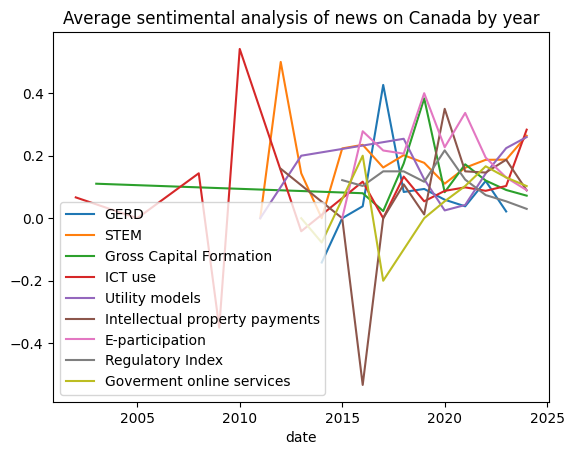

In [ ]:
#calculate average and plot
avg_canada_GERD = df_CANADA_GERD.groupby('date').mean()['Polarity']
avg_canada_GERD.plot(label = "GERD")
avg_canada_STEM = df_CANADA_STEM.groupby('date').mean()['Polarity']
avg_canada_STEM.plot(label = "STEM")
avg_canada_GERD = df_CANADA_CanadaGrosscapitalformation.groupby('date').mean()['Polarity']
avg_canada_GERD.plot(label = "Gross Capital Formation")
avg_canada_STEM = df_CANADA_CanadaICTuse.groupby('date').mean()['Polarity']
avg_canada_STEM.plot(label = "ICT use")
avg_canada_GERD = df_CANADA_CanadaCanadaUtilitymodel.groupby('date').mean()['Polarity']
avg_canada_GERD.plot(label = "Utility models")
avg_canada_STEM = df_CANADA_canadaintellectualpropertypayment.groupby('date').mean()['Polarity']
avg_canada_STEM.plot(label = "Intellectual property payments")
avg_canada_GERD = df_CANADA_candaEparticipation.groupby('date').mean()['Polarity']
avg_canada_GERD.plot(label = "E-participation")
avg_canada_STEM = df_CANADA_candaregualtoryindex.groupby('date').mean()['Polarity']
avg_canada_STEM.plot(label = "Regulatory Index")
avg_canada_GERD = df_CANADA_govermentonlineservicecanada.groupby('date').mean()['Polarity']
avg_canada_GERD.plot(label = "Goverment online services")



plt.title("Average sentimental analysis of news on Canada by year")
plt.legend()
plt.show()

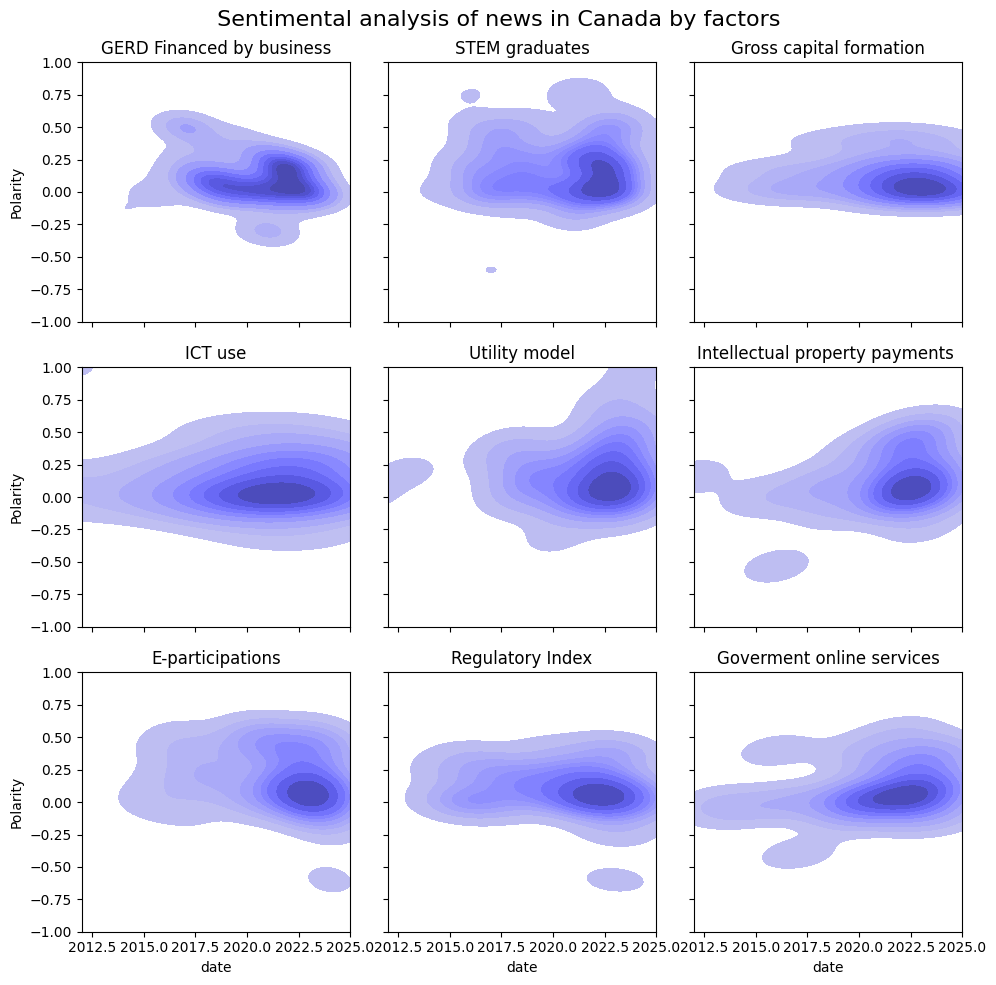

In [ ]:
#heatcloud plot Canada multifactor

# Create subplots
fig, axes = plt.subplots(3, 3, sharey=True,sharex=True, figsize=(10,10))
fig.suptitle(" Sentimental analysis of news in Canada by factors", fontsize=16)

sns.kdeplot(data=df_CANADA_GERD, x='date', y='Polarity', color='blue', ax=axes[0,0], fill = True)
axes[0,0].set_title('GERD Financed by business')

sns.kdeplot(data=df_CANADA_STEM, x='date', y='Polarity', color='blue', ax=axes[0,1], fill = True)
axes[0,1].set_title('STEM graduates')

sns.kdeplot(data=df_CANADA_CanadaGrosscapitalformation, x='date', y='Polarity', color='blue', ax=axes[0,2], fill = True)
axes[0,2].set_title('Gross capital formation')

sns.kdeplot(data=df_CANADA_CanadaICTuse, x='date', y='Polarity', color='blue', ax=axes[1,0], fill = True)
axes[1,0].set_title('ICT use')

sns.kdeplot(data=df_CANADA_CanadaCanadaUtilitymodel, x='date', y='Polarity', color='blue', ax=axes[1,1], fill = True)
axes[1,1].set_title('Utility model')

sns.kdeplot(data=df_CANADA_canadaintellectualpropertypayment, x='date', y='Polarity', color='blue', ax=axes[1,2], fill = True)
axes[1,2].set_title('Intellectual property payments ')

sns.kdeplot(data=df_CANADA_candaEparticipation, x='date', y='Polarity', color='blue', ax=axes[2,0], fill = True)
axes[2,0].set_title('E-participations')

sns.kdeplot(data=df_CANADA_candaregualtoryindex, x='date', y='Polarity', color='blue', ax=axes[2,1], fill = True)
axes[2,1].set_title('Regulatory Index')

sns.kdeplot(data=df_CANADA_govermentonlineservicecanada, x='date', y='Polarity', color='blue', ax=axes[2,2], fill = True)
axes[2,2].set_title('Goverment online services')



# Adjust layout
plt.xlim(2012,2025)
plt.ylim(-1,1)

plt.tight_layout()
plt.show()

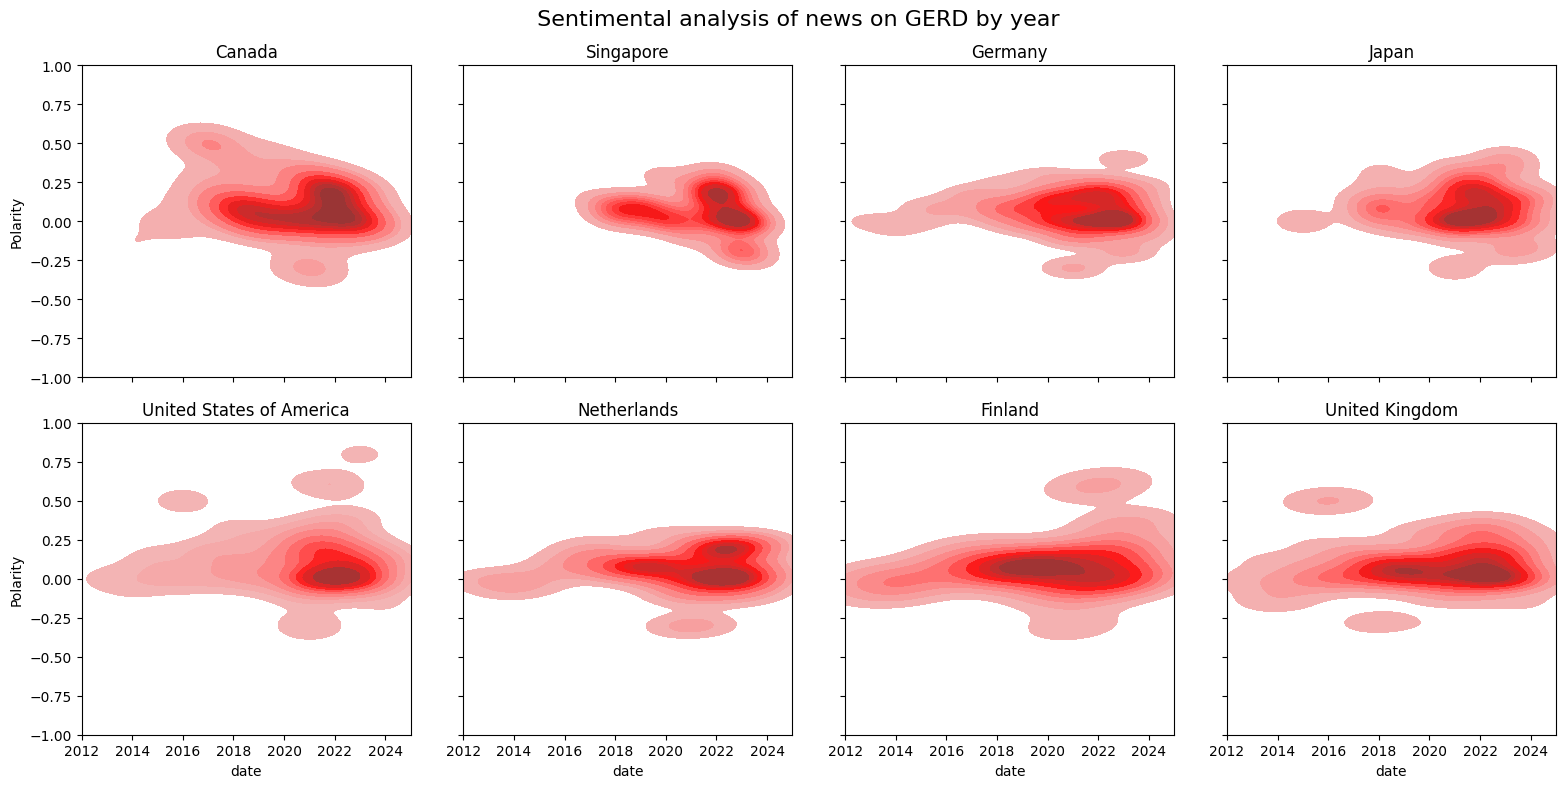

In [ ]:
#heat cloud plot GERD

# Create subplots
fig, axes = plt.subplots(2, 4, sharey=True,sharex=True, figsize=(16,8))
fig.suptitle(" Sentimental analysis of news on GERD by year", fontsize=16)

sns.kdeplot(data=df_CANADA_GERD, x='date', y='Polarity', color='red',ax=axes[0,0], fill = True)
axes[0,0].set_title('Canada')

sns.kdeplot(data=df_US_GERD, x='date', y='Polarity', color='red' ,ax=axes[1,0], fill = True)
axes[1,0].set_title('United States of America')


sns.kdeplot(data=df_GERMANY_GERD, x='date', y='Polarity', color='red' ,ax=axes[0,2], fill = True)
axes[0,2].set_title('Germany')

sns.kdeplot(data=df_JAPAN_GERD, x='date', y='Polarity', color='red' ,ax=axes[0,3], fill = True)
axes[0,3].set_title('Japan')

sns.kdeplot(data=df_SINGAPORE_GERD, x='date', y='Polarity', color='red' ,ax=axes[0,1], fill = True)
axes[0,1].set_title('Singapore')

sns.kdeplot(data=df_NETHERLANDS_GERD, x='date', y='Polarity', color='red' ,ax=axes[1,1], fill = True)
axes[1,1].set_title('Netherlands')

sns.kdeplot(data=df_FINLAND_GERD, x='date', y='Polarity', color='red' ,ax=axes[1,2], fill = True)
axes[1,2].set_title('Finland')

sns.kdeplot(data=df_UK_GERD, x='date', y='Polarity', color='red' ,ax=axes[1,3], fill = True)
axes[1,3].set_title('United Kingdom')


# Adjust layout
plt.xlim(2012,2025)
plt.ylim(-1,1)

plt.tight_layout()
plt.show()

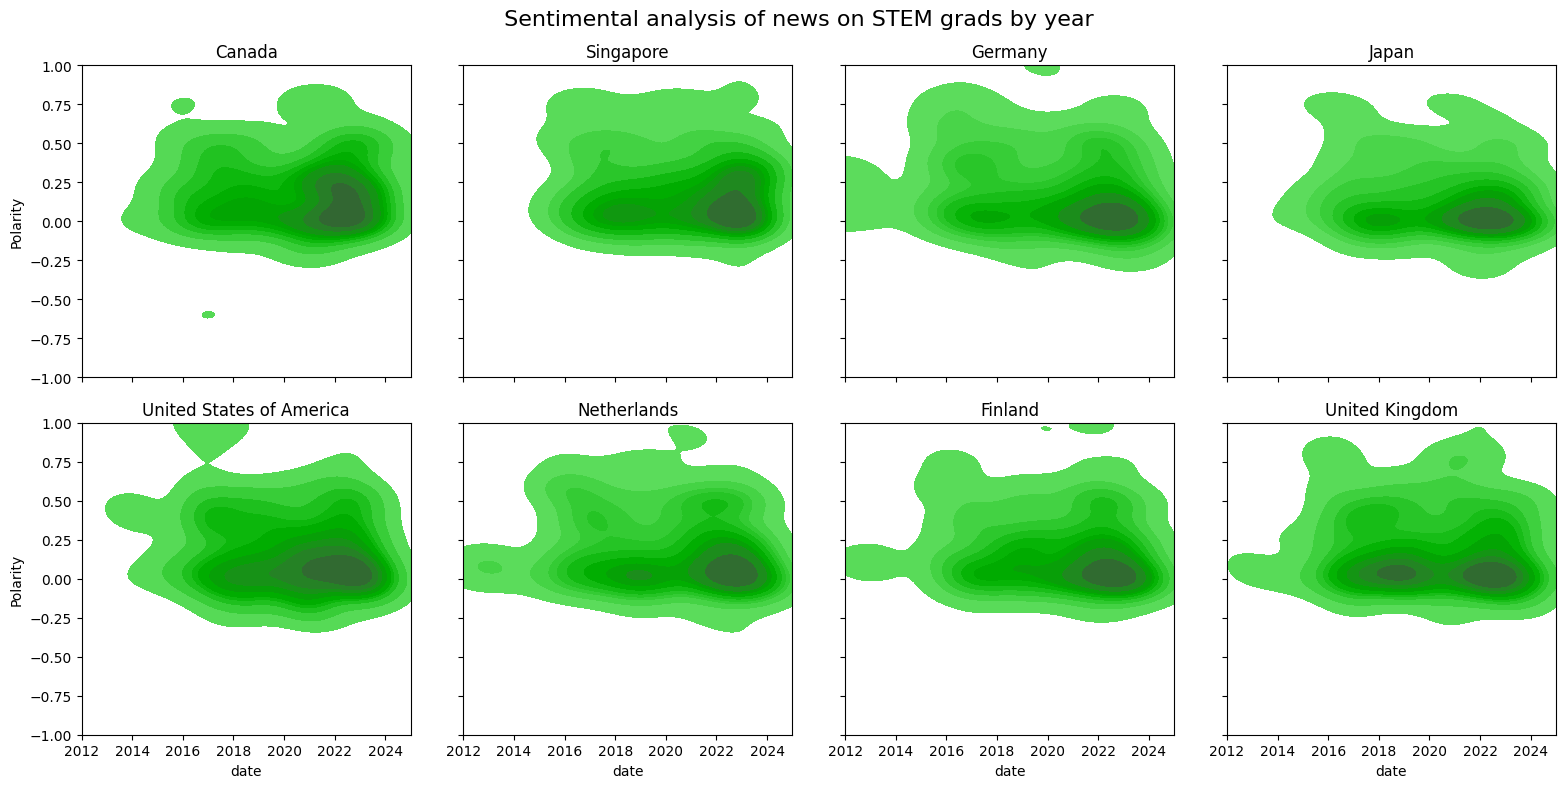

In [ ]:
#heatcloud plot STEM grads

# Create subplots
fig, axes = plt.subplots(2, 4, sharey=True,sharex=True, figsize=(16,8))
fig.suptitle(" Sentimental analysis of news on STEM grads by year", fontsize=16)


sns.kdeplot(data=df_CANADA_STEM, x='date', y='Polarity', color='green',ax=axes[0,0], fill = True)
axes[0,0].set_title('Canada')

sns.kdeplot(data=df_US_STEM, x='date', y='Polarity', color='green' ,ax=axes[1,0], fill = True)
axes[1,0].set_title('United States of America')


sns.kdeplot(data=df_GERMANY_STEM, x='date', y='Polarity', color='green' ,ax=axes[0,2], fill = True)
axes[0,2].set_title('Germany')

sns.kdeplot(data=df_JAPAN_STEM, x='date', y='Polarity', color='green' ,ax=axes[0,3], fill = True)
axes[0,3].set_title('Japan')

sns.kdeplot(data=df_SINGAPORE_STEM, x='date', y='Polarity', color='green' ,ax=axes[0,1], fill = True)
axes[0,1].set_title('Singapore')

sns.kdeplot(data=df_NETHERLANDS_STEM, x='date', y='Polarity', color='green' ,ax=axes[1,1], fill = True)
axes[1,1].set_title('Netherlands')

sns.kdeplot(data=df_FINLAND_STEM, x='date', y='Polarity', color='green' ,ax=axes[1,2], fill = True)
axes[1,2].set_title('Finland')

sns.kdeplot(data=df_UK_STEM, x='date', y='Polarity', color='green' ,ax=axes[1,3], fill = True)
axes[1,3].set_title('United Kingdom')


# Adjust layout
plt.xlim(2012,2025)
plt.ylim(-1,1)

plt.tight_layout()
plt.show()

# Google Drive PDF reading and strategies extractions

In [ ]:
def extract_text_from_pdf(pdf_path): #defining a function that reads the PDF files and returns a text
    text = ""
    with open(pdf_path, 'rb') as f:
        pdf_reader = PyPDF2.PdfReader(f)
        for page_num in range(len(pdf_reader.pages)):
            page = pdf_reader.pages[page_num]
            text += page.extract_text()+"\n\n"
    return text

In [ ]:
def extract_key_strategies(text): #defining a function to get the main 5 strategies mentioned
    # Prompt for the model
    prompt = "Analyze the text and extract the main strategies used to increase innovation, return a single bulleted list with no additional comments: '{}'".format(text[1500:65000])

    # Send prompt to the API
    client = OpenAI()
    response = client.chat.completions.create(
      model = model,
      max_tokens=150,
      messages = [
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": prompt}
      ]
    )

    return response.choices[0].message.content

In [ ]:
def Unite_keys(text): #defining a function to compare the strategies done by the countries/companies and getting the best 20 of them
    # Prompt for the model
    prompt = "Given the list provided, extract the main 40 distinct strategies to increase innovation, accounting for variations in articulation, return a single bulleted list with no additional comments: '{}'".format(text)

    # Send prompt to the API
    client = OpenAI()
    response = client.chat.completions.create(
      model = model,
      max_tokens=500,
      messages = [
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": prompt}
      ]
    )

    return response.choices[0].message.content

In [ ]:
def Countries_compare(text1,text2): #defining a function to compare the strategies done by the canada vs the other countries/companies

    total_text = "first list" + "\n\n" + text1 + "\n\n" + "second list" + "\n\n" + text2

    # Prompt for the model
    prompt = "Given the two text provided, return the best 10 strategies or approaches mentioned in the first list but not in the second list, accounting for variations in articulation, return a single bulleted list with no additional comments: '{}'".format(total_text)

    # Send prompt to the API
    client = OpenAI()
    response = client.chat.completions.create(
      model = model,
      max_tokens=500,
      messages = [
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": prompt}
      ]
    )

    return response.choices[0].message.content

In [ ]:
#reading the renamed countries' PDF files and storing their values in the generated variables
pdf_path = ["Dubai.pdf", "EU_1.pdf", "EU_2.pdf", "Japan.pdf", "Korea.pdf", "Singapore.pdf", "Switzerland.pdf", "UK_1.pdf", "UK_2.pdf", "UK_3.pdf", "UK_4.pdf", "UK_5.pdf", "USA_1.pdf", "USA_2.pdf", "USA_3.pdf"]
Countries = [Country.split('.')[0] for Country in pdf_path]

for Country in Countries:
    globals()[Country] = ""

for pdf in pdf_path:
  Country = pdf.split('.')[0]
  globals()[Country] = extract_text_from_pdf(pdf)

#downloading the PDF files text as txt files
for Country in Countries:
  file_name = Country + ".txt"
  with open(file_name, "w") as file:
    file.write(globals()[Country])

In [ ]:
#generating variables to store the extracted strategies
Countries_keys = [Country + "_keys" for Country in Countries]
for Country_keys in Countries_keys:
    globals()[Country_keys] = ""

#extracting the key strategies
for Country in Countries:
  globals()[Country+ "_keys"] = extract_key_strategies(globals()[Country])

#downloading the extracted strategies as txt files
for Country_keys in Countries_keys:
  file_name = Country_keys + ".txt"
  with open(file_name, "w") as file:
    file.write(globals()[Country_keys])

In [ ]:
#combining the keys and downloading them
Total_countries_keys = ""
for Country_keys in Countries_keys:
  Total_countries_keys = Total_countries_keys + "\n" + globals()[Country_keys]

with open("Total_countries_keys.txt", "w") as file:
  file.write(Total_countries_keys)

In [ ]:
#checking the uniquness of the keys
Unique_countries_keys = Unite_keys(Total_countries_keys)

with open("Unique_countries_keys.txt", "w") as file:
  file.write(Unique_countries_keys)

In [ ]:
#reading canada's pdf files
pdf_path_2 = ["Canada_1.pdf", "Canada_2.pdf", "Canada_3.pdf", "Canada_4.pdf", "Canada_5.pdf", "Canada_6.pdf", "Canada_7.pdf"]
Canada = [canada_file.split('.')[0] for canada_file in pdf_path_2]
Canada_keys = [canada_key + "_keys" for canada_key in Canada]
Total_canada_keys = ""

for canada_file in Canada:
    globals()[canada_file] = ""

for canada_key in Canada_keys:
    globals()[canada_key] = ""

#getting the key strategies mentioned in those pdfs
for pdf in pdf_path_2:
  canada_file = pdf.split('.')[0]
  canada_key = canada_file + "_keys"
  globals()[canada_file] = extract_text_from_pdf(pdf)
  globals()[canada_key] = extract_key_strategies(globals()[canada_file])
  Total_canada_keys = Total_canada_keys + "\n" + globals()[canada_key]

with open("Total_canada_keys.txt", "w") as file:
  file.write(Total_canada_keys)

In [ ]:
#making sure of their uniquness
Unique_canada_keys = Unite_keys(Total_canada_keys)

with open("Unique_canada_keys.txt", "w") as file:
  file.write(Unique_canada_keys)

In [ ]:
#comparing canada's strategies with the rest of the countries' and taking suggestions
Canada_suggested_keys_1 = Countries_compare(Unique_countries_keys, Unique_canada_keys)

with open("Canada_suggested_keys_1.txt", "w") as file:
  file.write(Canada_suggested_keys_1)

In [ ]:
#reading the renamed companies' PDF files and storing their values in generated variables
pdf_path_3 = ["Accenture_1.pdf", "Accenture_2.pdf", "Deloitte_1.pdf", "Deloitte_2.pdf", "Deloitte_3.pdf", "McKinsey.pdf", "OPSI_1.pdf", "OPSI_2.pdf", "OPSI_3.pdf", "PwC_1.pdf", "PwC_2.pdf"]
Companies = [Company.split('.')[0] for Company in pdf_path_3]

for Company in Companies:
    globals()[Company] = ""

for pdf in pdf_path_3:
  Company = pdf.split('.')[0]
  globals()[Company] = extract_text_from_pdf(pdf)

#downloading the PDF files text as txt files
for Company in Companies:
  file_name = Company + ".txt"
  with open(file_name, "w") as file:
    file.write(globals()[Company])

In [ ]:
#generating variables to store the extracted strategies
Companies_keys = [Company + "_keys" for Company in Companies]
for Company_keys in Companies_keys:
    globals()[Company_keys] = ""

#extracting the key strategies
for Company in Companies:
  globals()[Company+ "_keys"] = extract_key_strategies(globals()[Company])

#downloading the extracted strategies as txt files
for Company_keys in Companies_keys:
  file_name = Company_keys + ".txt"
  with open(file_name, "w") as file:
    file.write(globals()[Company_keys])

In [ ]:
#combining the keys and downloading them
Total_companies_keys = ""
for Company_keys in Companies_keys:
  Total_companies_keys = Total_companies_keys + "\n" + globals()[Company_keys]

with open("Total_companies_keys.txt", "w") as file:
  file.write(Total_companies_keys)

In [ ]:
#checking the uniquness of the keys
Unique_companies_keys = Unite_keys(Total_companies_keys)

with open("Unique_companies_keys.txt", "w") as file:
  file.write(Unique_companies_keys)

In [ ]:
#comparing canada's strategies with the rest of the countries' and taking suggestions
Canada_suggested_keys_2 = Countries_compare(Unique_companies_keys, Unique_canada_keys)

with open("Canada_suggested_keys_2.txt", "w") as file:
  file.write(Canada_suggested_keys_2)

# Quantitative values extraction

In [ ]:
#function to assign numbers to each line in the provided text
def convert_to_numbered_list(text):
    lines = text.split('\n')
    numbered_list = ""
    for i, line in enumerate(lines, 1):
        numbered_list += f"{i}. {line}\n"
    return numbered_list

In [ ]:
#assigning numbers to the extracted strategies as an indication to their country of origin
Total_countries_keys_numbered = convert_to_numbered_list(Total_countries_keys)

with open("Total_countries_keys_numbered.txt", "w") as file:
  file.write(Total_countries_keys_numbered)

In [ ]:
def Categorising_keys(text): #defining a function to sort the strategies done by the countries/companies into the specified categories
    # Prompt for the model
    prompt = "Sort each line in this list (including the point number) into one of the following categories: Technology and Digital Utilization, Sustainability and Renewable Energy, Skills Development and Education, International Collaboration and Partnerships, Standards Development and Governance: '{}'".format(text)

    # Send prompt to the API
    client = OpenAI()
    response = client.chat.completions.create(
      model = model,
      max_tokens=4096,
      messages = [
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": prompt}
      ]
    )

    return response.choices[0].message.content

In [ ]:
Categorised_countries_keys = Categorising_keys(Total_countries_keys_numbered)

with open("Categorised_countries_keys.txt", "w") as file:
  file.write(Categorised_countries_keys)

In [ ]:
####run to get the same results
with open("Categorised_countries_keys_best.txt", 'r') as file:
  Categorised_countries_keys = file.read()

In [ ]:
def starts_with_number(line): #function to count the number of strategies in each category
    pattern = r'^\s*\d'
    return re.match(pattern, line) is not None

# Initialize counts for each category
categories_count = {
    "Technology and Digital Utilization": 0,
    "Sustainability and Renewable Energy": 0,
    "Skills Development and Education": 0,
    "International Collaboration and Partnerships": 0,
    "Standards Development and Governance": 0
}

# Split the text by newlines to get each line separately
lines = Categorised_countries_keys.split("\n")

# Iterate through each line and count the occurrences of categories
current_category = None
for line in lines:
    if line.strip().endswith(":"):
        current_category = line.strip()[:-1]
    elif starts_with_number(line):
        categories_count[current_category] += 1

for category, count in categories_count.items():
    print(f"{category}: {count}")

Technology and Digital Utilization: 22
Sustainability and Renewable Energy: 9
Skills Development and Education: 10
International Collaboration and Partnerships: 9
Standards Development and Governance: 19


<ipython-input-112-fc63c54238ce>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=values, palette='viridis', alpha=0)


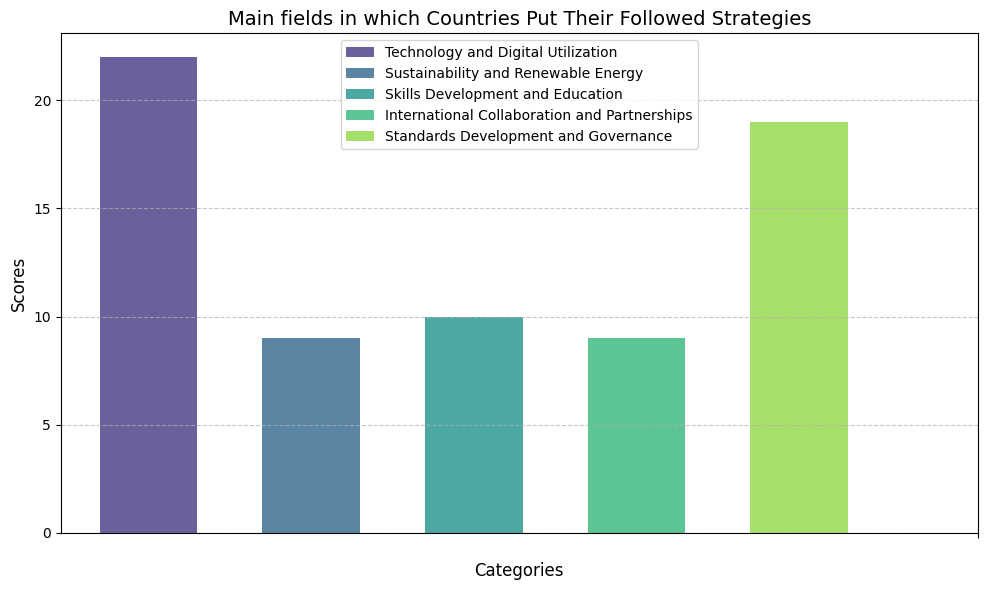

In [ ]:
labels = list(categories_count.keys())
values = list(categories_count.values())

# Creating the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=labels, y=values, palette='viridis', alpha=0)
bars = plt.bar(labels, values, color=sns.color_palette('viridis', len(labels)), alpha=0.8)
plt.legend(bars, labels, loc='best')
plt.xlabel('Categories', fontsize=12)
plt.ylabel('Scores', fontsize=12)
plt.title('Main fields in which Countries Put Their Followed Strategies', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(' ')
for bar in bars:
    bar.set_width(0.6)
plt.tight_layout()
plt.show()

In [ ]:
Categorised_countries_keys_sorted = Categorised_countries_keys

In [ ]:
#mapping done manually by studying and reviewing the API output
mappings = {
    'USA': list(range(57, 69)),
    'UK': list(range(37, 57)),
    'Switzerland': list(range(33, 37)),
    'Singapore': list(range(29, 33)),
    'Korea': list(range(25, 29)),
    'Japan': list(range(21, 25)),
    'EU': list(range(11, 21)),
    'dubai': list(range(1, 11))
}

#mapping the numbers to the country of origin
for key, value in mappings.items():
    for num in value:
        Categorised_countries_keys_sorted = Categorised_countries_keys_sorted.replace(str(num) + '.', f'{key}')

In [ ]:
####run to get the same results
with open('Categorised_countries_keys_sorted_best.txt', 'r') as file:
  Categorised_countries_keys_sorted = file.read()

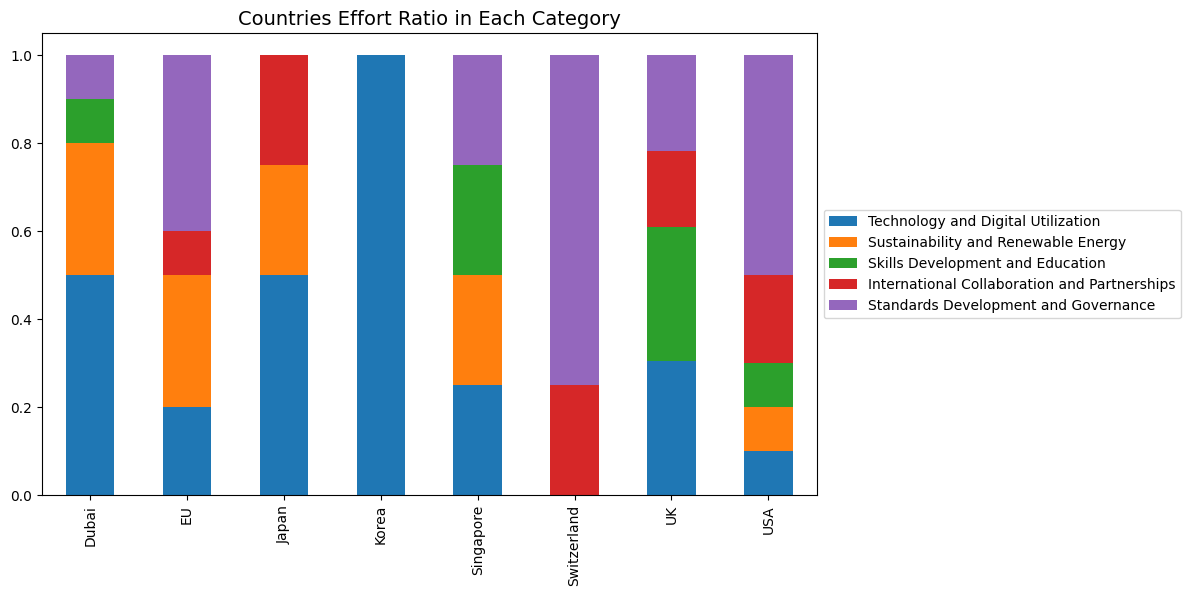

In [ ]:
#creating a dataframe with each country's contribution
columns_countries_efforts = ["Technology and Digital Utilization",
           "Sustainability and Renewable Energy",
           "Skills Development and Education",
           "International Collaboration and Partnerships",
           "Standards Development and Governance"]

rows_countries_efforts = ['Dubai', 'EU', 'Japan', 'Korea', 'Singapore', 'Switzerland', 'UK', 'USA']

countries_efforts = pd.DataFrame(0, index=rows_countries_efforts, columns=columns_countries_efforts)

lines_2 = Categorised_countries_keys_sorted.split("\n")

#going throught the text and counting
current_category = None
for line in lines_2:
    if line.strip().endswith(":"):
        current_category = line.strip()[:-1]
    elif line.strip().startswith("d"):
        countries_efforts.at['Dubai', current_category] += 1
    elif line.strip().startswith("EU"):
        countries_efforts.at['EU', current_category] += 1
    elif line.strip().startswith("J"):
        countries_efforts.at['Japan', current_category] += 1
    elif line.strip().startswith("K"):
        countries_efforts.at['Korea', current_category] += 1
    elif line.strip().startswith("Si"):
        countries_efforts.at['Singapore', current_category] += 1
    elif line.strip().startswith("Sw"):
        countries_efforts.at['Switzerland', current_category] += 1
    elif line.strip().startswith("UK"):
        countries_efforts.at['UK', current_category] += 1
    elif line.strip().startswith("USA"):
        countries_efforts.at['USA', current_category] += 1


countries_efforts_normalized = countries_efforts.div(countries_efforts.sum(axis=1), axis=0)

countries_efforts_normalized.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Countries Effort Ratio in Each Category', fontsize=14)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [ ]:
countries_efforts_normalized.to_csv('countries_efforts.csv')

# Now for the fun part: Attempt to creat a picture for the strategies used

In [ ]:
def Summarisation_for_drawings(text): #defining a function to summarize the strategies
    # Prompt for the model
    prompt = "Summarise these points into a 2 line paragraph: '{}'".format(text)

    # Send prompt to the API
    client = OpenAI()
    response = client.chat.completions.create(
      model = model,
      max_tokens=500,
      messages = [
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": prompt}
      ]
    )

    return response.choices[0].message.content

In [ ]:
Countries_keys_sum = [Country_keys + "_sum" for Country_keys in Countries_keys]
for Country_keys in Countries_keys:
  globals()[Country_keys+'_sum'] = Summarisation_for_drawings(globals()[Country_keys])

In [ ]:
#propt generation
Total_countries_keys_sum = "Dedicate a section in the image to simply visualise each of the following without any words:" + "\n"

for country_keys_sum in Countries_keys_sum:
  if country_keys_sum.startswith("D"):
    Total_countries_keys_sum = Total_countries_keys_sum + "\n" + "Dubai" + "\n" + globals()[country_keys_sum]
  elif country_keys_sum.startswith("EU"):
    Total_countries_keys_sum = Total_countries_keys_sum + "\n" + "EU" + "\n" + globals()[country_keys_sum]
  elif country_keys_sum.startswith("Japan"):
    Total_countries_keys_sum = Total_countries_keys_sum + "\n" + "Japan" + "\n" + globals()[country_keys_sum]
  elif country_keys_sum.startswith("Korea"):
    Total_countries_keys_sum = Total_countries_keys_sum + "\n" + "Korea" + "\n" + globals()[country_keys_sum]
  elif country_keys_sum.startswith("Sin"):
    Total_countries_keys_sum = Total_countries_keys_sum + "\n" + "Sin" + "\n" + globals()[country_keys_sum]
  elif country_keys_sum.startswith("Sw"):
    Total_countries_keys_sum = Total_countries_keys_sum + "\n" + "Sw" + "\n" + globals()[country_keys_sum]
  elif country_keys_sum.startswith("UK"):
    Total_countries_keys_sum = Total_countries_keys_sum + "\n" + "UK" + "\n" + globals()[country_keys_sum]
  elif country_keys_sum.startswith("USA"):
    Total_countries_keys_sum = Total_countries_keys_sum + "\n" + "USA" + "\n" + globals()[country_keys_sum]

In [ ]:
print(Total_countries_keys_sum)

In [ ]:
#prompt after filtering
image_prompt = """Dedicate a section in the image to simply visualise each of the following without any words:

Dubai:
Efforts are being made to increase collaboration between humans and machines, utilize synthetic biology across sectors, exploit open data for economic gain, advance cybersecurity in small businesses and charities, and harness renewable energy sources. Additionally, there's a focus on ESG marketplaces for sustainable investing, developing smart and sustainable cities, exploring AI and social robots for social services, fostering creativity and innovation in the economy, and leveraging technology for mental health care.

European Union:
To fortify European democracy, policies and innovations encouraging political participation, accountability, and inclusion are crucial, alongside enhancing democratic awareness and understanding the media's political dialogue role. Priorities include supporting the European Agenda on Security, the EU Civil Protection Mechanism, and public health initiatives such as cancer battling efforts. Emphasising the integral part of research and innovation in combating disinformation, addressing health issues, ensuring citizens' involvement, promoting social inclusivity, equality in R&I activities, and communication of European R&I value to the public is paramount.

Japan:
Efforts will be directed towards advancing R&D in transformative technologies like AI and quantum technology, with a special focus on deep learning for broad-based utilization. The creation of digital twins and sustainability applications enhances agile crisis response, while strengthening innovation hubs ensures symbiotic collaboration between industry, academia, and government. This is underpinned by an integrated innovation strategy involving the combination of public-private R&D investment, enhanced venture capital market, and the implementation of measures that foster continuous startup growth.

Korea:
The national data centers are being meticulously planned along with the migration of all government and public entities to Cloud. Led by the institution of a new Digital Strategy, the focus is on promoting the use of Software as a Service (SaaS) and driving governmental innovation with emerging technologies.

Singapore:
The focus is on enriching local technological infrastructure through technology transfer from foreign multinational corporations, investments in science parks, and bolstering the small and medium-sized enterprise sector. High-tech innovation is emphasized through national science and technology plans, complemented by robust government support for research and development activities.

Switzerland:
Research and Development, alongside Framework Conditions and Market Entry, form the core of innovations, bolstered by support from Innovation Agencies and International Collaboration. The process is further stabilized by a robust Legal System and the safeguarding of Intellectual Property Protection.

United Kingdom:
The goal is to prioritize technology-based partnerships globally, empower UK researchers in new collaborations, and enhance scientific cooperation between the UK and international research powerhouses. This includes the creation of innovative science partnership models with alike institutions and pursuit of defense and security collaborations in the areas of cyber capabilities and artificial intelligence.

United State of America:
There is an urgent need to boost R&D funding, bolstering a robust foundation for future standards development, focusing on risk, security, and resilience. Additionally, it's crucial to eliminate hindrances and encourage private sector involvement in this domain, enhance communication between public and private sectors, and amplify the representation and influence of the U.S. Government and allied nations in international standards governance and leadership."""

DALLE-20240321_224124.png


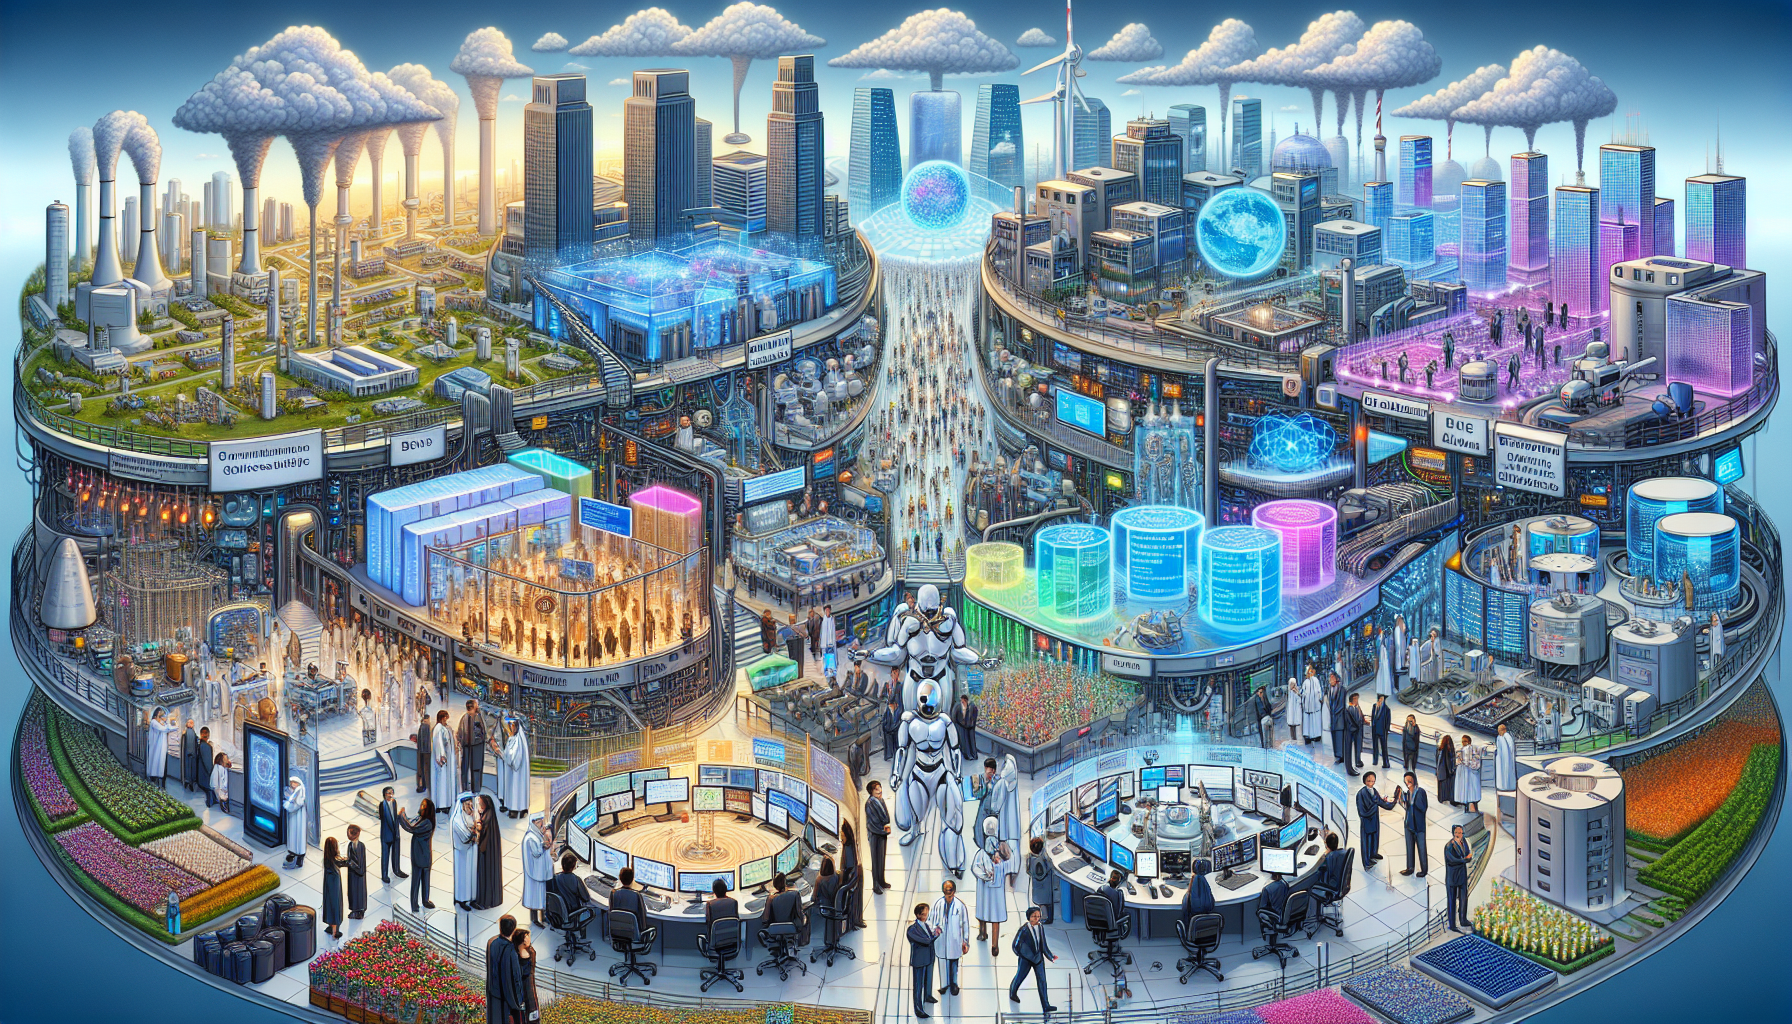

In [ ]:
model_p = "dall-e-3"
client_p = OpenAI()

response1 = client_p.images.generate(
    model = model_p,
    prompt = image_prompt,
    size = '1792x1024',
    quality = "standard",
    style = "vivid",
    n = 1,
)

image_url1 = response1.data[0].url

images_dt = datetime.utcfromtimestamp(response1.created)
img_filename = images_dt.strftime('DALLE-%Y%m%d_%H%M%S')+'.png'

generated_image = requests.get(image_url1).content  # download the image
with open(img_filename, "wb") as image_file:
    image_file.write(generated_image)  # write the image to the file

print(img_filename)
display(Image.open(img_filename))